# Analysis

In this notebook we'll analyze the data we've extracted before. Our goal here is to get more insights into games that Hikaru played and check if "interesting" streak that GM Kramnik referred to contains any unusual patterns that may lead us to think that Hikaru may be cheating.

To understand some of the stats/data we are working here you have to be familiar with data we extracted and enriched in [data](data.ipynb). 

Here I'll just install some libs that we'll need for future work in this notebook.

In [1]:
!pip install pandas matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install tabulate
!pip install pingouin
!pip install statsmodels



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns
import pingouin as pg

pd.options.mode.chained_assignment = None  # default='warn'


Load the data we have extracted

In [3]:
with open('./data/enriched/enriched_games_2023.jsonl', 'r') as json_file:
    all_games = [json.loads(line) for line in json_file]

/Users/vedadzornic/dev-mc/sources/ml/hikaru-cheating-analysis/venv/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


and convert them into pandas data frame

In [4]:
all_games_df = pd.json_normalize(all_games)

all_games_df = all_games_df.query('rules != "chess960"')


Now we will add some more columns that may be useful for our statistic to this dataframe

In [5]:
all_games_df['win'] = all_games_df['hikaru_stats.win'] * 100
all_games_df['timeout_win'] = all_games_df['hikaru_stats.is_timeout_win'] * 100
all_games_df['win1'] = all_games_df['hikaru_stats.was_losing_gte_1_but_won'] * 100
all_games_df['win2'] = all_games_df['hikaru_stats.was_losing_gte_2_but_won'] * 100
all_games_df['win3'] = all_games_df['hikaru_stats.was_losing_gte_3_but_won'] * 100
all_games_df['win4'] = all_games_df['hikaru_stats.was_losing_gte_4_but_won'] * 100
all_games_df['win5'] = all_games_df['hikaru_stats.was_losing_gte_5_but_won'] * 100
all_games_df['hikaru_color'] = all_games_df.apply(lambda row: 'White' if row['white.username'] == "Hikaru"  else 'Black', axis=1)
all_games_df['draw'] = all_games_df.apply(lambda row: (True if row.get('white.result', None) in ['repetition', 'agreed', 'insufficient', 'stalemate', '50move', 'timevsinsufficient'] else False) * 100, axis=1)

def is_game_lost(row):
    color = row['hikaru_color'].lower()
    result = row[f'{color}.result']
    
    return True if result in ['resigned', 'timeout', 'checkmated'] else False

def get_win_reason(row):
    #get opponent color to get loosing reason
    if row['win'] == 100:
        color = 'white' if row['hikaru_color'].lower() == 'black' else 'black'
        return row[f'{color}.result']
    return None

all_games_df['win_reason'] = all_games_df.apply(lambda row: get_win_reason(row), axis=1)
all_games_df['loose'] = all_games_df.apply(lambda row: is_game_lost(row) * 100, axis=1)

all_games_df['hikaru_stats.good_moves_perc_sum'] = all_games_df['hikaru_stats.best_move_perc'] + all_games_df['hikaru_stats.excellent_move_perc'] + all_games_df['hikaru_stats.good_move_perc']
all_games_df['hikaru_stats.bad_moves_perc_sum'] = all_games_df['hikaru_stats.inaccuracy_move_perc'] + all_games_df['hikaru_stats.mistake_move_perc'] + all_games_df['hikaru_stats.blunder_move_perc']

all_games_df['opponent_stats.good_moves_perc_sum'] = all_games_df['opponent_stats.best_move_perc'] + all_games_df['opponent_stats.excellent_move_perc'] + all_games_df['opponent_stats.good_move_perc']
all_games_df['opponent_stats.bad_moves_perc_sum'] = all_games_df['opponent_stats.inaccuracy_move_perc'] + all_games_df['opponent_stats.mistake_move_perc'] + all_games_df['opponent_stats.blunder_move_perc']

bins = range(2000, 3500, 100)  # creating rating range buckets
all_games_df['rating_bin'] = pd.cut(all_games_df['hikaru_stats.opponent_rating'], bins=bins)
all_games_df['main_time_control'] = all_games_df['time_control'].apply(lambda x: int(x.split('+')[0]))
all_games_df['increment'] = all_games_df['time_control'].apply(lambda x: 0 if len(x.split('+')) == 1  else int(x.split('+')[1]))
all_games_df['timestamp'] = pd.to_datetime(all_games_df['end_time'], unit='s')


Now we will isolate "interesting" streak games into separate DF.

In [6]:
start_streak_uuid = '5c232585-84b8-11ee-9446-6cfe544c0428'
end_streak_uuid = 'e565825f-858a-11ee-9c40-6cfe544c0428'

streak_start_index = all_games_df.index[all_games_df['uuid'] == start_streak_uuid].tolist()[0]
streak_end_index = all_games_df.index[all_games_df['uuid'] == end_streak_uuid].tolist()[0]
streak_games_df = all_games_df.iloc[streak_start_index:streak_end_index+1]

streak_games_df['time_control'].value_counts()


time_control
180      22
180+1    22
Name: count, dtype: int64

As observed, all 44 streak games are 3+0 blitz games. Now to have fair statistics, we will isolate all Hikaru's 3+0 streak games and exclude this interesting streak games so in our analysis we can compare one to another.

In [7]:

ids_to_exclude = streak_games_df['uuid'].tolist()

filtered_by_180_time_control_df = all_games_df.query('main_time_control == 180 & increment == 0 & rules')

blitz_180_no_streak_df = filtered_by_180_time_control_df[~filtered_by_180_time_control_df['uuid'].isin(ids_to_exclude)]
blitz_180_no_streak_df['time_control'].value_counts()

time_control
180    3632
Name: count, dtype: int64

So we have 3632 blitz 3+0 games that we will use as base for behaviour of Hikaru. In our analysis we will compare Hikaru's streak games to this data frame.

## On winning

In this section we'll cover some stats on win data. To start off, let see how often does Hikaru win and with what color does that happen more often. As blitz makes the majority of Hikarus games, we'll use all_blitz_df from now on to produce stats.

In [8]:
blitz_180_no_streak_df.groupby('hikaru_color').agg(
    {
        'win': 'mean',
        'draw': 'mean',
        'loose': 'mean',
        'timeout_win': 'mean'
     }
)

,win,draw,loose,timeout_win
hikaru_color,,,,
Black,78.306586,8.688434,12.396237,10.902048
White,83.178082,6.520548,9.753425,9.534247


What we see above is that Hikaru does have great win percentage in blitz, and it appears to be normally distributed for both piece colors. What is a little bit surprising is that Hikaru wins 78% of the time with black pieces as black is often considered as defensively oriented role. This shows that Hikaru has great chances of overturning roles in his games and winning lots of games even with black. 

Hikaru will loose only 13% of the time with black or 10% of the time with white pieces.

Also, what we see here is that ~1 out of 10 games Hikaru will win on time which means Hikaru is able to "flag" opponents quite often.

In [9]:
grouped_by_opponent = blitz_180_no_streak_df.groupby('hikaru_stats.opponent_username', observed=True)

grouped_by_opponent['hikaru_stats.opponent_username'].count().sort_values(ascending=False).head(5)

hikaru_stats.opponent_username
alexrustemov     117
artooon          108
NikoTheodorou     88
0gZPanda          84
Firouzja2003      80
Name: hikaru_stats.opponent_username, dtype: int64

These are 5 players Hikaru played against most. As we can tell he does play often against same players, let's now add their average elo rating.

In [10]:
top_5_opponents = grouped_by_opponent['hikaru_stats.opponent_username'].count().sort_values(ascending=False).head(5).index
top_5_df = blitz_180_no_streak_df[blitz_180_no_streak_df['hikaru_stats.opponent_username'].isin(top_5_opponents)]

top_5_df.groupby('hikaru_stats.opponent_username').agg({'hikaru_stats.opponent_rating': 'mean'}).loc[top_5_opponents]

,hikaru_stats.opponent_rating
hikaru_stats.opponent_username,
alexrustemov,2876.666667
artooon,2985.398148
NikoTheodorou,3050.011364
0gZPanda,3001.583333
Firouzja2003,3090.800000


We can tell that top two players have quite lower rating than Hikaru while others fluctuate around 3050 which is still significantly lower rating than what Hikaru has (~3200). Now such difference in rating on chess.com does not necessarily mean that Hikaru may win always against these opponents as they themselves are also strong GMs, however it does mean that Hikaru is better and has better experience in using chess.com platform.

Let's now add some other stats on these top 5. Primarily I want to see what is Hikaru win percentage against each of them and percentages on wins on time.

In [11]:
top_5_df['win'] = top_5_df['hikaru_stats.win'] * 100
top_5_df['timeout_win'] = top_5_df['hikaru_stats.is_timeout_win'] * 100

top_5_df.groupby('hikaru_stats.opponent_username').agg(
    {
        'hikaru_stats.opponent_rating': 'mean',
        'win': 'mean',
        'draw': 'mean',
        'loose': 'mean',
        'timeout_win': 'mean'
     }
).loc[top_5_opponents]


,hikaru_stats.opponent_rating,win,draw,loose,timeout_win
hikaru_stats.opponent_username,,,,,
alexrustemov,2876.666667,85.470085,6.837607,6.837607,29.059829
artooon,2985.398148,74.074074,8.333333,17.592593,1.851852
NikoTheodorou,3050.011364,56.818182,18.181818,25.000000,9.090909
0gZPanda,3001.583333,72.619048,9.523810,17.857143,4.761905
Firouzja2003,3090.800000,42.5,23.750000,33.750000,1.25


We can tell that winning percentage plays well with opponent rating, as higher the opponent rating is less likely it is for Hikaru to win. What surprised me is to see that against alexrustemov Hikaru won almost 30% of games on time. This is surprisingly large number and if anything it tells us that alexrustemov should work on his time management or stop playing Hikaru at all.

On other note Hikaru scored not so well against NikoTheodorou and Firouzja2003, winning just 56% and 41% which, compared to ratings, did result in Hikaru loosing his rating points.


What I want to see now is what is percentage of games that during the game Hikaru was loosing but won anyway. If you remember, in our data extraction we extracted 5 fields where hikaru was loosing by margins of 1,2,3,4,5 but won anyway so lets see this data.

In [12]:
top_5_df.groupby('hikaru_stats.opponent_username').agg(
    {
        'hikaru_stats.opponent_rating': 'mean',
        'win1': 'mean',
        'win2': 'mean',
        'win3': 'mean',
        'win4': 'mean',
        'win5': 'mean',
     }
).loc[top_5_opponents]

,hikaru_stats.opponent_rating,win1,win2,win3,win4,win5
hikaru_stats.opponent_username,,,,,,
alexrustemov,2876.666667,44.444444,20.512821,11.965812,8.547009,2.564103
artooon,2985.398148,28.703704,13.888889,8.333333,7.407407,7.407407
NikoTheodorou,3050.011364,38.636364,14.772727,7.954545,4.545455,2.272727
0gZPanda,3001.583333,39.285714,14.285714,8.333333,7.142857,4.761905
Firouzja2003,3090.800000,25.0,12.5,8.75,3.75,2.5


The provided statistics align with expectations, and no unusual patterns are present. Hikaru Nakamura does have some chance of winning even when faced with a disadvantageous position. Nevertheless, as the evaluation indicating a losing position increases, his likelihood of winning decreases.

Let's now look at entire dataset but first lets split it into rating range buckets.

In [13]:
blitz_180_no_streak_df.groupby('rating_bin', observed=True)['hikaru_stats.opponent_rating'].count()

rating_bin
(2000, 2100]      15
(2100, 2200]      16
(2200, 2300]      20
(2300, 2400]      28
(2400, 2500]      69
(2500, 2600]      86
(2600, 2700]     162
(2700, 2800]     213
(2800, 2900]     906
(2900, 3000]    1198
(3000, 3100]     680
(3100, 3200]      91
(3200, 3300]       2
Name: hikaru_stats.opponent_rating, dtype: int64

<Figure size 1500x600 with 0 Axes>

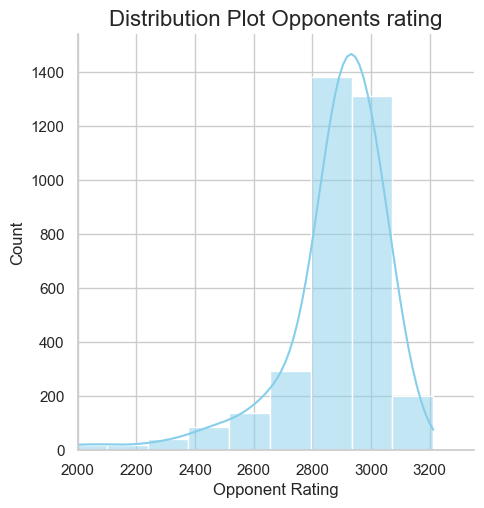

In [14]:
sns.set(style="whitegrid")

plt.figure(figsize=(15, 6))
sns.displot(blitz_180_no_streak_df['hikaru_stats.opponent_rating'], kde=True, bins=20, color='skyblue')

# Title and labels
plt.title('Distribution Plot Opponents rating', fontsize=16)
plt.xlabel('Opponent Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlim(2000)

# Show the plot
plt.show()

As we can tell from the distribution above, it is clear that a significant portion of his matches is against opponents with notably lower ratings, potentially contributing to his proficiency in farming elo rating. Typically, his opponents fall within the rating range of 2500 to 3200. However, the majority of his games are concentrated within the narrower span of 2800 to 3000.

Now, let's delve into additional statistics specific to each rating range.


In [15]:
blitz_180_no_streak_df.groupby('rating_bin', observed=True).agg(
    {
        'win': 'mean',
        'draw': 'mean', 
        'loose': 'mean', 
        'timeout_win': 'mean',
        'win1': 'mean',
        'win2': 'mean',
        'win3': 'mean',
        'win4': 'mean',
        'win5': 'mean',
     }
)


,win,draw,loose,timeout_win,win1,win2,win3,win4,win5
rating_bin,,,,,,,,,
"(2000, 2100]",93.333333,0.000000,0.000000,0.0,60.0,46.666667,26.666667,13.333333,6.666667
"(2100, 2200]",68.75,0.000000,6.250000,0.0,43.75,37.5,31.25,25.0,18.75
"(2200, 2300]",100.0,0.000000,0.000000,25.0,60.0,40.0,40.0,35.0,20.0
"(2300, 2400]",78.571429,0.000000,7.142857,14.285714,53.571429,32.142857,25.0,21.428571,17.857143
"(2400, 2500]",98.550725,0.000000,1.449275,13.043478,50.724638,26.086957,21.73913,17.391304,14.492754
"(2500, 2600]",91.860465,2.325581,4.651163,11.627907,53.488372,38.372093,24.418605,19.767442,16.27907
"(2600, 2700]",94.444444,1.851852,3.086420,11.111111,51.851852,27.777778,19.135802,13.580247,11.728395
"(2700, 2800]",95.305164,2.347418,2.347418,10.328638,44.600939,23.004695,17.370892,13.14554,8.920188
"(2800, 2900]",89.403974,5.298013,5.187638,13.245033,44.15011,23.509934,15.562914,11.92053,8.278146


The statistics within each rating range appear consistent with expectations. Generally, as Hikaru's opponent rating range increases he does have less chance of winning. Same apply for situations where Hikaru was loosing but won at the end; as the higher opponent elo is it is harder for Hikaru to make comeback from loosing position. 

Let's now see these stats for the "interesting" streak games and see if they deviate from what we saw so far. We'll also take a subset from above table which is relevant for streak games.

In [16]:
blitz_180_no_streak_agg_df = blitz_180_no_streak_df.groupby('rating_bin', observed=True).agg(
    {
        'win': ['count', 'mean'],
        'timeout_win': 'mean',
        'win1': 'mean',
        'win2': 'mean',
        'win3': 'mean',
        'win4': 'mean',
        'win5': 'mean',
     }
).iloc[9:11, :]
blitz_180_no_streak_agg_df

win            timeout_win       win1       win2       win3  \
             count       mean        mean       mean       mean       mean   
rating_bin                                                                   
(2900, 3000]  1198  79.131886    9.599332  39.232053  19.365609  13.105175   
(3000, 3100]   680  62.794118    8.970588  34.411765  17.352941  11.911765   

                  win4      win5  
                  mean      mean  
rating_bin                        
(2900, 3000]  9.348915  6.343907  
(3000, 3100]  8.823529  6.176471

In [17]:
streak_agg_df = streak_games_df.groupby('rating_bin', observed=True).agg(
    {
        'win': ['count', 'mean'],
        'timeout_win': 'mean',
        'win1': 'mean',
        'win2': 'mean',
        'win3': 'mean',
        'win4': 'mean',
        'win5': 'mean',
     }
)
streak_agg_df

win            timeout_win       win1       win2       win3  \
             count       mean        mean       mean       mean       mean   
rating_bin                                                                   
(2500, 2600]     3      100.0         0.0  66.666667        0.0        0.0   
(2600, 2700]     2      100.0         0.0       50.0       50.0        0.0   
(2700, 2800]     2      100.0         0.0      100.0        0.0        0.0   
(2800, 2900]     6  83.333333         0.0  33.333333        0.0        0.0   
(2900, 3000]    14  85.714286    7.142857  64.285714  35.714286  28.571429   
(3000, 3100]    13  46.153846    7.692308  30.769231  15.384615  15.384615   
(3100, 3200]     3  33.333333         0.0        0.0        0.0        0.0   
(3300, 3400]     1        0.0         0.0        0.0        0.0        0.0   

                   win4 win5  
                   mean mean  
rating_bin                    
(2500, 2600]        0.0  0.0  
(2600, 2700]        0.0  0.0  
(2700, 2800]        0.0  0.0  
(2800, 2900]        0.0  0.0  
(2900, 3000]  21.428571  0.0  
(3000, 3100]   7.692308  0.0  
(3100, 3200]        0.0  0.0  
(3300, 3400]        0.0  0.0

Here we can see that streak games do have higher numbers compared to overall dataset. However, as we cherry-picked specific winning streak such differences do not have to be necessarily an unusual pattern. Fact that all these cherry-picked games likely play a role in seeing these numbers higher than what we see in entire data set. However, it does mean that ~8% of the time, when played 2900-3000 rating during his streak, Hikaru was lost by 8 but won anyway. Let's find these wins and what was a winning reason.

In [18]:
streak_games_df.query('win5 == 100').groupby('rating_bin', observed=True)['win_reason'].value_counts()

Series([], Name: count, dtype: int64)

So there were 3 games where Hikaru was loosing by 5 and won anyway. Two of them he won on time, frequently referred as flagged opponent. In last one his opponent resigned, so lets look a specific details of this game. Let's pull this game and see if there is anything unusual with it.

In [19]:
lost_by_5_but_won = streak_games_df.query('win5 == 100 & win_reason == "resigned"').head(1)
lost_by_5_but_won[['url','hikaru_stats.opponent_username', 'hikaru_stats.good_moves_perc_sum', 'hikaru_stats.bad_moves_perc_sum', 'opponent_stats.good_moves_perc_sum', 'opponent_stats.bad_moves_perc_sum']]

,url,hikaru_stats.opponent_username,hikaru_stats.good_moves_perc_sum,hikaru_stats.bad_moves_perc_sum,opponent_stats.good_moves_perc_sum,opponent_stats.bad_moves_perc_sum


Apparently this game was played against LiamPutnam2008. You can check game details on https://www.chess.com/game/live/93910817501 but what I found out is that on move 29 Hikaru made serious mistake of playing Bd8.
<br>
<img src="data/photos/liamputnam_game_loosing_5plus.png" width="1200" height="800" />

At this point Hikaru was lost by 5+ eval. Several moves have been played after this move where both sides were making mistakes, however Liamputnam2008 did make a crucial blunder loosing a knight which lead him to loose the game. Hikaru did spend 2 seconds on playing move which took advantage on the blunder and the move itself does not seem too hard to find even for my limited chess knowledge. 

At this point I do not see anything unusual with this game but that LiamPutnam2008 did really play a bad game and let Hikaru win even though he was practically lost. I did check fide ratings for Liam Putnam and his blitz rating in fide list is 2157 therefore it does make sense for Hikaru to keep playing even though he was lost in middlegame as he has a lot of chances to win these games being overrated and better player in general.

After we checked games where Hikaru was lost by 5+ but won anyway in streak games, lest also check what are common winning reasons for all loosing but won buckets.

In [20]:
# Win 5 we have already covered
lost_by_N_but_won = streak_games_df.query('(win1 == 100 | win2 == 100 | win3 == 100 | win4 == 100) & win5 != 100')
lost_by_N_but_won['win_reason'].value_counts()

win_reason
resigned      16
timeout        2
checkmated     2
Name: count, dtype: int64

So out of 18 games, 13 were won by resignation of opponent and 5 were won on timeout. Again, timeout wins are not really interesting to us as Hikaru was able to flag opponents, however we want to get some more insights in these 13 so lets start by seeing their move's percentage.

In [21]:
lost_by_N_but_won_by_resignation = lost_by_N_but_won.query('win_reason == "resigned"')

lost_by_N_but_won_by_resignation_renamed = lost_by_N_but_won_by_resignation.rename(columns={
    'hikaru_stats.opponent_username': 'Opponent',
    'hikaru_stats.opponent_rating': 'Opponent elo',
    'hikaru_stats.total_moves': 'Moves count',
    'hikaru_stats.good_moves_perc_sum': 'Hikaru good moves %',
    'hikaru_stats.bad_moves_perc_sum': 'Hikaru bad moves %',
    'opponent_stats.good_moves_perc_sum':  'Opponent Good moves %',
    'opponent_stats.bad_moves_perc_sum': 'Opponent bad moves %',
    'opponent_stats.blunder_move_perc': 'Opponent blunders %'
})

lost_by_N_but_won_by_resignation_renamed[['Opponent', 'Opponent elo', 'Moves count', 'Hikaru good moves %', 'Hikaru bad moves %', 'Opponent Good moves %', 'Opponent bad moves %', 'Opponent blunders %', 'url' ]]


,Opponent,Opponent elo,Moves count,Hikaru good moves %,Hikaru bad moves %,Opponent Good moves %,Opponent bad moves %,Opponent blunders %,url
4195,BrandonJacobson,3093.0,43.0,90.909091,9.090909,84.848485,15.151515,0.000000,https://www.chess.com/game/live/94084277327
4197,BrandonJacobson,3087.0,42.0,75.000000,25.000000,75.000000,25.000000,6.250000,https://www.chess.com/game/live/94086199953
4201,NikoTheodorou,3094.0,53.0,81.395349,18.604651,76.744186,23.255814,4.651163,https://www.chess.com/game/live/94089750087
4202,Mouse-Sleep,2525.0,32.0,63.636364,36.363636,47.619048,52.380952,14.285714,https://www.chess.com/game/live/94321378147
4203,The_Machine04,2666.0,37.0,81.481481,18.518519,74.074074,25.925926,3.703704,https://www.chess.com/game/live/94321996121
4205,ckgchess,2878.0,25.0,100.000000,0.000000,66.666667,33.333333,0.000000,https://www.chess.com/game/live/94323223533
4206,artooon,2985.0,59.0,69.387755,30.612245,64.583333,35.416667,6.250000,https://www.chess.com/game/live/94324359799
4217,Tactrics,2907.0,69.0,77.966102,22.033898,75.862069,24.137931,5.172414,https://www.chess.com/game/live/94345880895
4219,BillieKimbah,2988.0,50.0,87.500000,12.500000,89.743590,10.256410,2.564103,https://www.chess.com/game/live/94347098175
4222,eljanov,2868.0,50.0,90.000000,10.000000,76.923077,23.076923,2.564103,https://www.chess.com/game/live/94348971501


Let's analyze these 13 games, first by checking into the stats we have and then if necessarily by checking in details some games. 
<br>


##### First 4 games

First 4 games in table above (sorted by moves count) seem to be regular games where opponent (likely due to tilt factor) blundered early and resigned game figuring out it would be hard for them to recover vs Hikaru. In 2 of them Hikaru did perform by having 90%+ good moves percentage. However, give the low amount of played moves it is hard to judge these games as even all of these could be Hikaru's preparation or opening theory.

<br>

##### 4171 - Game against Pe0la 

In this [game](https://www.chess.com/game/live/93977534149) Hikaru was lost by 2+. The game itself had 39 moves and on move 27 Pe0la made a blunder which gave Hikaru chance to survive and even out odds. Hikaru did make a best move taking 12 seconds to play it. Hikaru had more than 1 minute left on his clock when he made this move while his opponent did have 35 seconds left so likely Hikaru did not feel time pressure. The move itself does not seem to be hard to find, and it is classified by best by chess.com not great nor brilliant. After this move Pe0la made several bad moves allowing Hikaru to take advantage and win at the end.

As I said above, the move does not seem to be hard to find. However, it did took Hikaru 12 seconds to play which (as we will cover below in section on moves) is long time for Hikaru. 

<br>

##### Rest of the games

I will not do this analysis for all the 13 games, however I did check few more samples and it does seem that it is usually up to the opponents that make a bad moves and not up to Hikaru to make good moves. Usually these players will make a bunch of mistakes in middlegame where Hikaru will play just regular (obvious) good moves without burning a lot of time. Also, in lots of these games opponents may be feeling time pressure as Hikaru will usually play fast and be in a big advantage on clock.



### On winning summary

So far we did see some "interesting" and a lot of non "interesting" stats. GM Hikaru is usually playing lower rated players, and he does win a lot. When playing such players he does have less stress as he can more easily make comeback from worst position. Hikaru will usually play fast, and beat opponents on clock or put a lot of stress on them due to time advantage. More often it is up to the opponents who make a bad moves and loose their advantage then it is up to Hikaru of making good moves.

Against higher rated players Hikaru would have much lower chances on making such streak as he does win much less and have fewer chances to recover from worst position.

Let's now move to analyze moves data within these games.

## On moves

Here we will examine moves statistic and compare in with other data in our datasets. More specifically we want to see how many good moves Hikaru plays under which condition and how does that affect his winning chances. If you remember, during our data extraction we did extract some stats on move classification which ranges from Excellent - Blunder, however we also did add stats on a column which represent whether the specific move was one of the top 2 moves offered by stockfish.
<br>
### Top two moves percentage

Let's start by plotting distribution of top 2 moves percentage accross games.

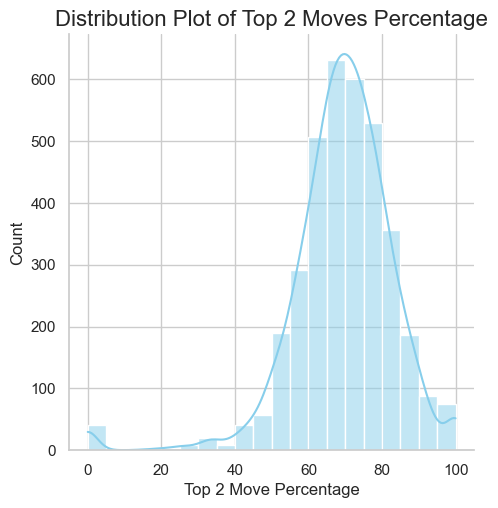

In [22]:
sns.displot(blitz_180_no_streak_df['hikaru_stats.top_2_move_perc'], kde=True, bins=20, color='skyblue')

plt.title('Distribution Plot of Top 2 Moves Percentage', fontsize=16)
plt.xlabel('Top 2 Move Percentage', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

In [23]:
blitz_180_no_streak_df['hikaru_stats.top_2_move_perc'].describe()

count    3632.000000
mean       69.264149
std        13.924904
min         0.000000
25%        62.500000
50%        70.000000
75%        77.777778
max       100.000000
Name: hikaru_stats.top_2_move_perc, dtype: float64

We can tell that data is sort of normally distributed and that majority of games did have top two moves percentage between 60% and 80%. However, standard deviation for this type of data (percentages) seem to be high as two standard deviations cover anything in between 40% - 97% and based on distribution graph from above we can tell that < 40% are rare games.
 
What this means is that in 68% of the games Hikaru did play top two moves for ~ 60%-80% of the time, and in 95% of the games Hikaru did play top two moves for ~ 40%-100% of the time. As we can tell, this data is pretty much scattered around therefore does not tell us a lot.

Let's now see best move percentage per elo rating range and if that tells us more.

In [24]:
blitz_180_no_streak_df.groupby('rating_bin', observed=True)['hikaru_stats.top_2_move_perc'].describe()

,count,mean,std,min,25%,50%,75%,max
rating_bin,,,,,,,,
"(2000, 2100]",15.0,47.356196,26.803064,0.000000,41.477273,57.142857,64.796905,80.000000
"(2100, 2200]",16.0,61.087322,19.647127,30.000000,49.456522,60.882353,73.557692,92.857143
"(2200, 2300]",20.0,70.386435,17.504059,30.769231,59.285714,69.176636,85.178571,100.000000
"(2300, 2400]",28.0,69.098148,14.425222,45.833333,56.493506,69.917744,80.654762,100.000000
"(2400, 2500]",69.0,72.625674,11.992061,46.511628,63.157895,73.076923,80.645161,100.000000
"(2500, 2600]",86.0,71.804919,13.657212,0.000000,66.666667,72.170213,78.685410,100.000000
"(2600, 2700]",162.0,71.541213,13.216270,0.000000,65.000000,71.428571,78.907496,100.000000
"(2700, 2800]",213.0,71.623191,12.816579,0.000000,64.444444,72.000000,79.310345,100.000000
"(2800, 2900]",906.0,70.392339,11.723153,0.000000,63.157895,70.588235,77.777778,100.000000


Here we got a little bit more accurate numbers but still high standard deviation. Let's now see a stats for streak games and compare them to non streak games.


In [25]:
streak_games_df.groupby('rating_bin', observed=True)['hikaru_stats.top_2_move_perc'].describe()

,count,mean,std,min,25%,50%,75%,max
rating_bin,,,,,,,,
"(2500, 2600]",3.0,76.923077,16.254041,59.090909,69.930070,80.769231,85.839161,90.909091
"(2600, 2700]",2.0,71.666667,7.071068,66.666667,69.166667,71.666667,74.166667,76.666667
"(2700, 2800]",2.0,70.637409,7.241010,65.517241,68.077325,70.637409,73.197492,75.757576
"(2800, 2900]",6.0,74.340677,12.094138,56.060606,70.673077,75.000000,76.814516,93.333333
"(2900, 3000]",14.0,72.305528,7.916610,58.823529,65.811138,75.376344,79.500000,81.250000
"(3000, 3100]",13.0,70.570558,10.684120,58.441558,65.217391,69.767442,70.588235,100.000000
"(3100, 3200]",3.0,74.202341,11.038944,64.814815,68.121693,71.428571,78.896104,86.363636
"(3300, 3400]",1.0,72.222222,NaN,72.222222,72.222222,72.222222,72.222222,72.222222


We can tell that there is some difference by looking at the mean and standard deviation. We will now focus on 2900-3000 rating ranges and calculate coefficient of variation and compare streak games to non streak games.

The coefficient of variation (CV) is a relative measure of dispersion, and it tells us relative variability of each dataset. What we want to see is how different streak games CV is to the non streak games CV.

In [26]:
first_group_index = list(streak_games_df.groupby('rating_bin', observed=True).groups)[0]

streak_2900_3000 = streak_games_df.groupby('rating_bin', observed=True).get_group(first_group_index)['hikaru_stats.top_2_move_perc']

first_group_index = list(blitz_180_no_streak_df.groupby('rating_bin', observed=True).groups)[9]

no_streak_2900_3000 = blitz_180_no_streak_df.groupby('rating_bin', observed=True).get_group(first_group_index)['hikaru_stats.top_2_move_perc']

def calculate_cv(df):
    mean = df.mean()
    std = df.std()
    return (std/mean) * 100

print(f'Coefficient of variation for streak games is {calculate_cv(streak_2900_3000)} compared to non streak games {calculate_cv(no_streak_2900_3000)}')


Coefficient of variation for streak games is 21.130253271217196 compared to non streak games 16.219151580505624


As seen above both streak and non streak games have similar variability where their coefficient of variation is around 16%. As there is no high difference in variability we will expect that streak games do have similar properties to the non streak games in regard to top two moves percentage.

Let's now plot mean of top two percentage moves for both datasets we're working with.
We want to see if there is significant difference in mean of streak games when compared to other blitz games for rating range.

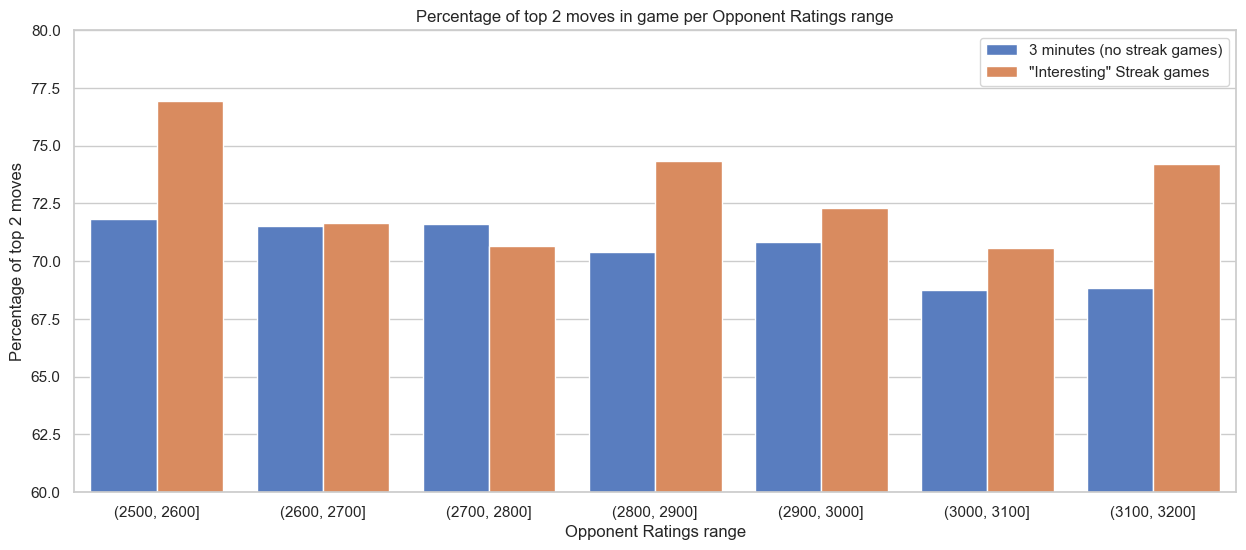

In [27]:
average_percentage_streak_games = streak_games_df.groupby('rating_bin', observed=True)['hikaru_stats.top_2_move_perc'].mean().reset_index()
average_percentage_blitz_180_no_streak = blitz_180_no_streak_df.groupby('rating_bin', observed=True)['hikaru_stats.top_2_move_perc'].mean().reset_index()

plt.figure(figsize=(15, 6))

combined_df = pd.concat([average_percentage_blitz_180_no_streak, average_percentage_streak_games], keys=['3 minutes (no streak games)', '"Interesting" Streak games'], names=['DataFrame']).reset_index()

sns.barplot(x='rating_bin', y='hikaru_stats.top_2_move_perc', hue='DataFrame', data=combined_df, palette='muted')

plt.title('Percentage of top 2 moves in game per Opponent Ratings range')
plt.xlabel('Opponent Ratings range')
plt.ylabel('Percentage of top 2 moves')
plt.axis([4.5, 11.5, 60, 80])
plt.legend()
plt.show()

Here we can tell that there is a difference in percentage of top 2 moves per game when we compare streak games vs blitz games. For elo rating range 2900 - 3000 difference is about 3% and for elo rating range 3000 - 3100 is about 7%. We can also see that majority of streak games are played for 2900 - 3000 elo rating range and only 6 games where Hikaru players were in elo range of 3000 - 3100. However, these percentage still fall into range of 60% - 80%.

We can also see that as the opponents rating elo increases best moves percentage of Hikaru slightly decreases.


In [28]:
bucket_one_diff = average_percentage_streak_games['hikaru_stats.top_2_move_perc'][0] - average_percentage_blitz_180_no_streak['hikaru_stats.top_2_move_perc'][9]
bucket_two_diff = average_percentage_streak_games['hikaru_stats.top_2_move_perc'][1] - average_percentage_blitz_180_no_streak['hikaru_stats.top_2_move_perc'][10]

print(f'Difference for elo rating range 2900 - 3000 is {bucket_one_diff}')
print(f'Difference for elo rating range 3000 - 3100 is {bucket_two_diff}')

Difference for elo rating range 2900 - 3000 is 6.073067019290306
Difference for elo rating range 3000 - 3100 is 2.9079826413015013


Let's try to isolate games from the streak which don't fall within one standard deviation of top 2 moves percentage and check on them.

In [29]:
std = blitz_180_no_streak_df['hikaru_stats.top_2_move_perc'].std()
mean = blitz_180_no_streak_df['hikaru_stats.top_2_move_perc'].mean()

not_within_std = streak_games_df[(streak_games_df['hikaru_stats.top_2_move_perc'] < mean - std) | (streak_games_df['hikaru_stats.top_2_move_perc'] > mean + std)]
not_within_std[['hikaru_stats.opponent_username', 'hikaru_stats.opponent_rating', 'hikaru_stats.total_moves', 'hikaru_stats.top_2_move_perc', 'url']]

,hikaru_stats.opponent_username,hikaru_stats.opponent_rating,hikaru_stats.total_moves,hikaru_stats.top_2_move_perc,url
4194,BrandonJacobson,3123.0,32.0,86.363636,https://www.chess.com/game/live/94082508503
4205,ckgchess,2878.0,25.0,93.333333,https://www.chess.com/game/live/94323223533
4213,Ykow,2508.0,21.0,90.909091,https://www.chess.com/game/live/94342960675
4218,jefferyx,3029.0,18.0,100.000000,https://www.chess.com/game/live/94346492515


There are 12 games from the "interesting" streak games where top 2 moves percentage is outside standard deviation. Some of these moves do have relatively small amount of moves that we take in consideration when calculating move ratings (we ignore first 10 moves as we consider them opening phase. Check data notebook for more on this). However, some of these games do have high percentage of top 2 moves even with higher number of moves therefore we will take sample of them to analyze.

<br>

##### Game 4150 Hikaru - Pe0la
This is 25 moves game and top two moves percentage made by Hikaru is 100%. This essentially means that last 15 moves of the game Hikaru played one of the two moves that are classified as best by stockfish. This game Hikaru won with accuracy of 97.4 with 4 great moves being played. 
First great move is on move 18 where Hikaru played Ra1:

<br>

<img src="data/photos/case2/great-move-1.png" width="700" height="700" />

<br>

Apparently this is first time in the game where Hikaru used more time for thinking, and it took him 23 seconds to play this move. The next great move made by Hikaru is on move 20 where he also took significant thinking time of 22 seconds.

<br> 

<img src="data/photos/case2/great-move-2.png" width="700" height="700" />

<br>

Next two greate moves were made rather instantaneously and game was quickly over after 25th move. Note that, even when taking longer thinking time on these two great moves Hikaru was still up on clock against his opponent which demonstrates excellent time management skills. 

<br><br>

##### Game 4186 Hikaru - legendisback1

In this game Hikaru in his opponent played 31 move where, even though he made one blunder which his opponent didn't take advantage of, Hikaru won with 93.9 accuracy. Advantage was given to Hikaru by his opponent on move 25 where he played bxc5.
<br> 

<img src="data/photos/case3/opponent_mistake_1.png" width="700" height="700" />

<br>

Hikaru played the best obvious move dxc5 instantly and his opponent quickly played Rb8 move. After this Hikaru took 36 seconds to play next move (b6) which according to stockfish evaluation is the best one and keeps advantage.

<br>
<img src="data/photos/case3/best_move_1.png" width="700" height="700" />
<br>

Shortly after this Hikaru was able to keep and increase his advantage which lead him to win on move 31. Similarly to the previous example, Hikaru was better on clock in this game and could afford spending time in such situations.

<br>

Even though we can see there are key situations where Hikaru took some time for thinking and played best moves it is not unusual for GM such as Hikaru to sense the key moments and spend more time on calculating variations. Given that Hikaru does play rather quickly he is able to "save" some time for later use when he can sense the moment may be key moment for thinking. 

Let's now go to another feature in our dataset which is subset of top two moves, only moves.


### Only moves 

Remember that in our data preparation we have extracted moves that we categorized as "only move". These are moves that beside being in top two, are in classification of excellent or best and do take advantage on fact that previous move by opponent was not good (in bad category). We want to compare how often does Hikaru recognize that opponent made a bad move and play against it with best moves to either make a comeback or increase winning chances. As in the previous analysis, lets start by plotting the distribution of only moves percentage across our games.

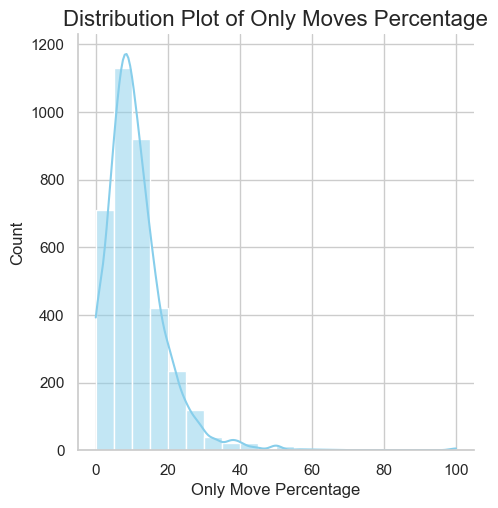

In [30]:
sns.displot(blitz_180_no_streak_df['hikaru_stats.only_move_perc'], kde=True, bins=20, color='skyblue')

plt.title('Distribution Plot of Only Moves Percentage', fontsize=16)
plt.xlabel('Only Move Percentage', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

In [31]:
blitz_180_no_streak_df['hikaru_stats.only_move_perc'].describe()

count    3632.000000
mean       11.176266
std         8.419090
min         0.000000
25%         5.882353
50%         9.677419
75%        14.705882
max       100.000000
Name: hikaru_stats.only_move_perc, dtype: float64

We can tell that unlike top two moves, only moves are much rarer in these games as majority of them is placed between 2% - 20% of all the moves. This also does make sense as only move does require previous opponent move to be a bad move which is not case for top two moves. Lets now see same data grouped by rating range.

In [32]:
blitz_180_no_streak_df.groupby('rating_bin', observed=True)['hikaru_stats.only_move_perc'].describe()

,count,mean,std,min,25%,50%,75%,max
rating_bin,,,,,,,,
"(2000, 2100]",15.0,7.920781,8.961411,0.000000,0.000000,8.510638,13.118280,25.000000
"(2100, 2200]",16.0,14.080060,9.581381,0.000000,6.785714,13.025210,18.870192,33.333333
"(2200, 2300]",20.0,14.115143,13.855119,2.040816,6.895604,10.882353,16.810345,66.666667
"(2300, 2400]",28.0,16.983357,12.162995,0.000000,8.333333,15.740741,22.916667,50.000000
"(2400, 2500]",69.0,15.111336,8.641873,0.000000,8.695652,14.814815,19.354839,40.000000
"(2500, 2600]",86.0,11.760355,12.207186,0.000000,5.797511,9.716758,14.600840,100.000000
"(2600, 2700]",162.0,11.582838,7.983028,0.000000,6.642171,10.172414,15.113636,50.000000
"(2700, 2800]",213.0,13.462811,8.630598,0.000000,7.843137,11.904762,17.647059,55.555556
"(2800, 2900]",906.0,12.079162,8.231529,0.000000,6.666667,10.690476,15.453297,100.000000


The trend that we saw with best moves is somewhat present here as well. As opponent rating is higher, average percentage of only moves tends to be smaller. For rating range of our interest (2900 - 3100) average is around 10% with standard deviation of 7.4. Let's now compare and plot this data with streak games to see if there are any unusual patterns and outliers in streak games.

In [33]:
streak_games_df.groupby('rating_bin', observed=True)['hikaru_stats.only_move_perc'].describe()

,count,mean,std,min,25%,50%,75%,max
rating_bin,,,,,,,,
"(2500, 2600]",3.0,9.673660,8.423115,0.000000,6.818182,13.636364,14.510490,15.384615
"(2600, 2700]",2.0,10.740741,5.761611,6.666667,8.703704,10.740741,12.777778,14.814815
"(2700, 2800]",2.0,14.707419,13.484534,5.172414,9.939916,14.707419,19.474922,24.242424
"(2800, 2900]",6.0,10.059873,9.550947,0.000000,3.555718,9.838710,11.875000,26.666667
"(2900, 3000]",14.0,12.115736,5.452971,5.000000,7.227603,11.352041,16.000000,22.222222
"(3000, 3100]",13.0,7.154917,4.129113,0.000000,6.097561,6.976744,9.375000,13.513514
"(3100, 3200]",3.0,4.541446,3.946885,0.000000,3.240741,6.481481,6.812169,7.142857
"(3300, 3400]",1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000


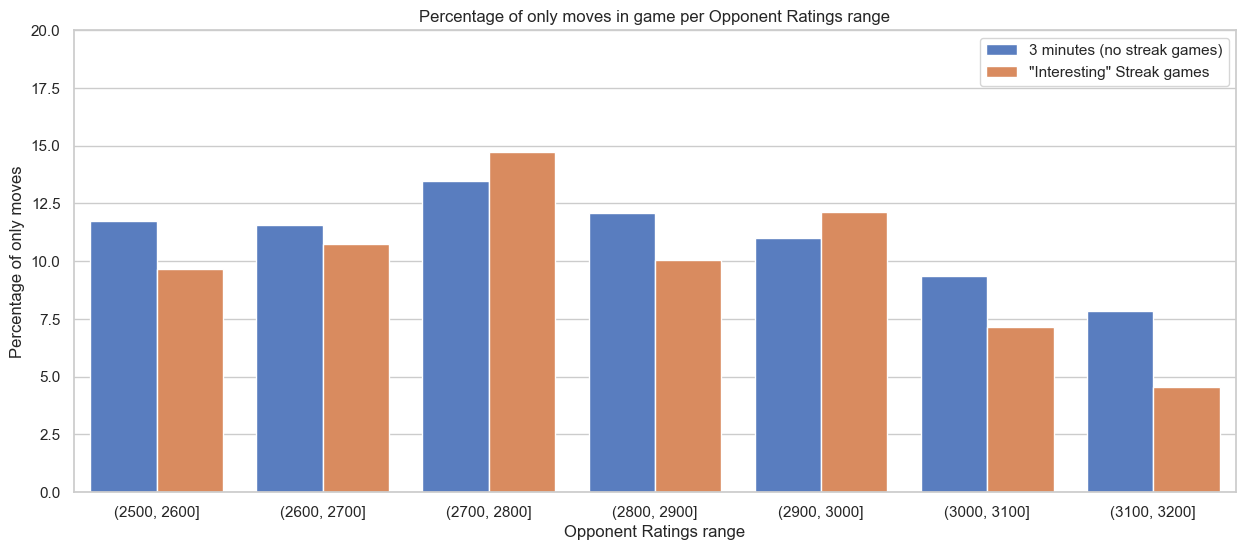

In [34]:
average_percentage_streak_games = streak_games_df.groupby('rating_bin', observed=True)['hikaru_stats.only_move_perc'].mean().reset_index()
average_percentage_blitz_180_no_streak = blitz_180_no_streak_df.groupby('rating_bin', observed=True)['hikaru_stats.only_move_perc'].mean().reset_index()

plt.figure(figsize=(15, 6))

combined_df = pd.concat([average_percentage_blitz_180_no_streak, average_percentage_streak_games], keys=['3 minutes (no streak games)', '"Interesting" Streak games'], names=['DataFrame']).reset_index()

sns.barplot(x='rating_bin', y='hikaru_stats.only_move_perc', hue='DataFrame', data=combined_df, palette='muted')

plt.title('Percentage of only moves in game per Opponent Ratings range')
plt.xlabel('Opponent Ratings range')
plt.ylabel('Percentage of only moves')
plt.axis([4.5, 11.5, 0, 20])
plt.legend()
plt.show()

Similarly to the top two moves, here as well we can see a difference in averages when we compare streak and non streak games. More interesting is that in at least one game Hikaru did have 100% of only moves, we will definitely be checking that one. So lets start with the same approach we used before, find outliers in streak games compared to non streak metrics and hand check them.

In [35]:
std = blitz_180_no_streak_df['hikaru_stats.only_move_perc'].std()
mean = blitz_180_no_streak_df['hikaru_stats.only_move_perc'].mean()

not_within_std = streak_games_df[(streak_games_df['hikaru_stats.only_move_perc'] < mean - std) | (streak_games_df['hikaru_stats.only_move_perc'] > mean + std)]
not_within_std[['hikaru_stats.opponent_username', 'hikaru_stats.opponent_rating', 'hikaru_stats.total_moves', 'hikaru_stats.only_move_perc', 'url']]

,hikaru_stats.opponent_username,hikaru_stats.opponent_rating,hikaru_stats.total_moves,hikaru_stats.only_move_perc,url
4194,BrandonJacobson,3123.0,32.0,0.000000,https://www.chess.com/game/live/94082508503
4205,ckgchess,2878.0,25.0,26.666667,https://www.chess.com/game/live/94323223533
4207,RaunakSadhwani2005,3064.0,33.0,0.000000,https://www.chess.com/game/live/94324967559
4210,MagnusCarlsen,3318.0,28.0,0.000000,https://www.chess.com/game/live/94327327601
4212,starworld123,2859.0,76.0,1.515152,https://www.chess.com/game/live/94328530879
4213,Ykow,2508.0,21.0,0.000000,https://www.chess.com/game/live/94342960675
4215,remi04,2827.0,23.0,0.000000,https://www.chess.com/game/live/94344158095
4218,jefferyx,3029.0,18.0,0.000000,https://www.chess.com/game/live/94346492515
4231,gurelediz,2952.0,30.0,20.000000,https://www.chess.com/game/live/94410174505
4232,gurelediz,2950.0,46.0,22.222222,https://www.chess.com/game/live/94410248093


So there are 8 games played by Hikaru in streak which our not within one standard deviation of all other 3+0 games. Some of them do have relatively small number of moves and given that we do not count opening moves these games are not relevant. For example, 100% only move game had 11 moves, which means it played only one move out of our opening move filter, and it was only move. However, we want to look at few games that do have higher number of total moves but still high percentage of only moves.

<br>

##### 4173 - Hikaru vs Pe0la

This is game in our outliers set which does have most moves, however I could not find anything "interesting" in this game. Only move that is worth reviewing was in the endgame when Pe0la did make a mistake by playing e5 with his pawn, basically giving Hikaru a pawn and big advantage. Hikaru did spend 5 seconds on playing best move there, but situation itself does not seem to be that complicated to me. Hikaru did end this game having 1.52 minute left on clock while his opponent was at 0.52.

<br> 

<img src="data/photos/case4/mistake_move.png" width="700" height="700" />

<br>

##### 4146 - Hikaru vs Artur0208

In this game Hikaru had 93.1% of accuracy and did have 2 brilliant and 2 great moves. The game at the end was full of tactics Hikaru found on his opponent and did have a great advantage. However, only moves were played rather quickly, and personally I do not see anything weird in only moves behaviour for this game. Hikaru did end the game with 1.37 minute left on clock while his opponent had 37 seconds.

<br>

Now that we saw averages of only moves per all game moves, let's see these averages relative to possible amount of only moves.

In [36]:
blitz_180_no_streak_df.groupby('rating_bin', observed=True)['hikaru_stats.only_move_relative_perc'].describe()


,count,mean,std,min,25%,50%,75%,max
rating_bin,,,,,,,,
"(2000, 2100]",15.0,26.018519,27.137800,0.000000,0.000000,25.000000,50.000000,66.666667
"(2100, 2200]",16.0,38.623737,23.796130,0.000000,24.305556,33.333333,54.166667,83.333333
"(2200, 2300]",20.0,51.547619,24.420231,16.666667,33.333333,43.650794,61.666667,100.000000
"(2300, 2400]",28.0,52.820939,24.469027,0.000000,41.250000,50.000000,68.750000,100.000000
"(2400, 2500]",69.0,53.211177,23.565825,0.000000,37.500000,50.000000,66.666667,100.000000
"(2500, 2600]",86.0,45.493492,25.747000,0.000000,33.333333,42.857143,62.259615,100.000000
"(2600, 2700]",162.0,48.963968,23.299961,0.000000,33.333333,50.000000,61.875000,100.000000
"(2700, 2800]",213.0,53.319549,24.591521,0.000000,37.500000,50.000000,66.666667,100.000000
"(2800, 2900]",906.0,49.939387,21.996021,0.000000,33.333333,50.000000,62.500000,100.000000


In [37]:
streak_games_df.groupby('rating_bin', observed=True)['hikaru_stats.only_move_relative_perc'].describe()

,count,mean,std,min,25%,50%,75%,max
rating_bin,,,,,,,,
"(2500, 2600]",3.0,27.380952,28.645737,0.000000,12.500000,25.000000,41.071429,57.142857
"(2600, 2700]",2.0,45.238095,16.835876,33.333333,39.285714,45.238095,51.190476,57.142857
"(2700, 2800]",2.0,61.111111,39.283710,33.333333,47.222222,61.111111,75.000000,88.888889
"(2800, 2900]",6.0,43.703704,29.678663,0.000000,25.000000,52.777778,58.888889,80.000000
"(2900, 3000]",14.0,44.911160,18.848111,20.000000,27.976190,47.222222,56.190476,83.333333
"(3000, 3100]",13.0,35.163725,20.736511,0.000000,22.222222,36.363636,50.000000,62.500000
"(3100, 3200]",3.0,41.666667,36.324158,0.000000,29.166667,58.333333,62.500000,66.666667
"(3300, 3400]",1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000


We can tell that in both cases mean is around 50% but is greater in streak games. This means that in average Hikaru did take more only moves after his opponent made a bad move. However, we can see that standard deviation for both datasets is significantly high meaning data is spread around pretty much everywhere.

Let's see the timeline over streak games and does it relate to percentage of only moves taken.



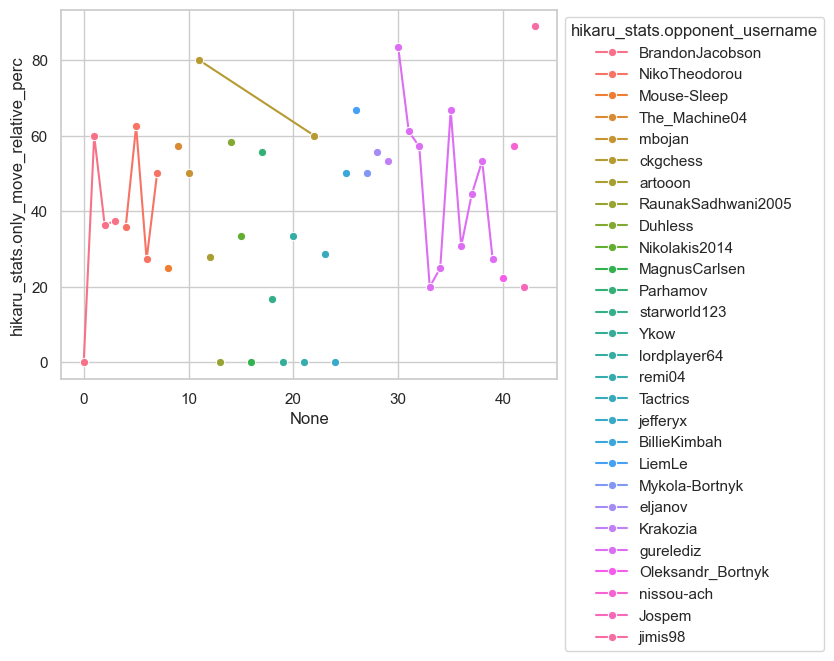

In [38]:
reindexed_df = streak_games_df.reset_index()

ax = sns.lineplot(x=reindexed_df.index, y='hikaru_stats.only_move_relative_perc', data=streak_games_df, marker='o', hue='hikaru_stats.opponent_username')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

As we can tell there is no clear pattern even if we look per opponent. Data is very dispersed and there is no trend within same player games. Given the data is pretty much scattered around, lets try to find a meaning to that. I would like to see whether this column correlates to any other columns we have in our dataset. Basically we're trying to find which columns do influence only move percentage.

In [39]:
data_for_correlation_matrix = blitz_180_no_streak_df[
    ['hikaru_stats.only_move_relative_perc',
     'hikaru_stats.total_moves',
     'hikaru_stats.only_move_avg',
     'hikaru_stats.opponent_rating',
     'opponent_stats.bad_moves_perc_sum'
     ]
]
data_for_correlation_matrix.corr()

,hikaru_stats.only_move_relative_perc,hikaru_stats.total_moves,hikaru_stats.only_move_avg,hikaru_stats.opponent_rating,opponent_stats.bad_moves_perc_sum
hikaru_stats.only_move_relative_perc,1.000000,-0.082529,0.166597,0.085398,0.023016
hikaru_stats.total_moves,-0.082529,1.000000,-0.072186,0.304279,-0.368680
hikaru_stats.only_move_avg,0.166597,-0.072186,1.000000,0.132649,0.070064
hikaru_stats.opponent_rating,0.085398,0.304279,0.132649,1.000000,-0.054960
opponent_stats.bad_moves_perc_sum,0.023016,-0.368680,0.070064,-0.054960,1.000000


Just by checking correlation between independent variables there does not seem to be strong correlation in regard to only_move_relative_perc. We will try to find correlation between different features of our dataset later in this notebook but for now we are done with only move stats.

We can say that only moves, similarly to top two moves do have some trend of being played more against weaker players but in general data for this metric is so much dispersed, so it is hard to bring any conclusion on it. Simple averaging it will tell us that Hikaru will play only move 50% of the time it was "offered" by opponent making a bad move and for streak games this number is off by ~10% almost reaching 60%. However, given streak games are cherry picked range of games with all Hikaru wins it is expected to have better performance compared to entire dataset. 

## Move classifications [Best - Blunder]

In this section we'll analyze moves as per chess.com classification from best to blunder.

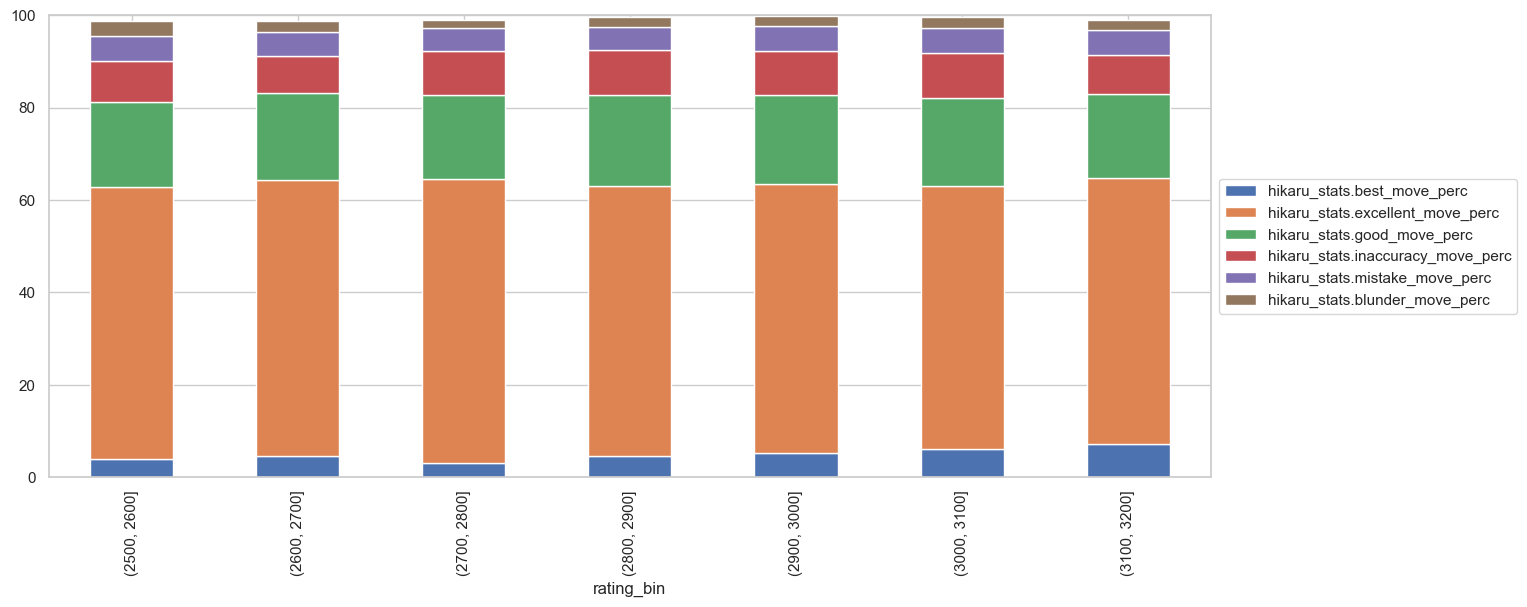

In [40]:
columns_to_stack = ['hikaru_stats.excellent_move_perc', 'hikaru_stats.best_move_perc', 'hikaru_stats.good_move_perc', 'hikaru_stats.inaccuracy_move_perc', 'hikaru_stats.mistake_move_perc', 'hikaru_stats.blunder_move_perc']

streak_games_classification_df = streak_games_df.groupby('rating_bin', observed=True).agg({
    'hikaru_stats.best_move_perc': 'mean',
    'hikaru_stats.excellent_move_perc': 'mean',
    'hikaru_stats.good_move_perc': 'mean',
    'hikaru_stats.inaccuracy_move_perc': 'mean',
    'hikaru_stats.mistake_move_perc': 'mean',
    'hikaru_stats.blunder_move_perc': 'mean'
}).reset_index()

all_blitz_no_streak_classification_df = blitz_180_no_streak_df.groupby('rating_bin', observed=True).agg({
    'hikaru_stats.best_move_perc': 'mean',
    'hikaru_stats.excellent_move_perc': 'mean',
    'hikaru_stats.good_move_perc': 'mean',
    'hikaru_stats.inaccuracy_move_perc': 'mean',
    'hikaru_stats.mistake_move_perc': 'mean',
    'hikaru_stats.blunder_move_perc': 'mean'
}).reset_index()


df_plt = all_blitz_no_streak_classification_df.set_index('rating_bin').plot(kind='bar', stacked=True, figsize=(15, 6))
df_plt.axis([4.5, 11.5, 0, 100])
df_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

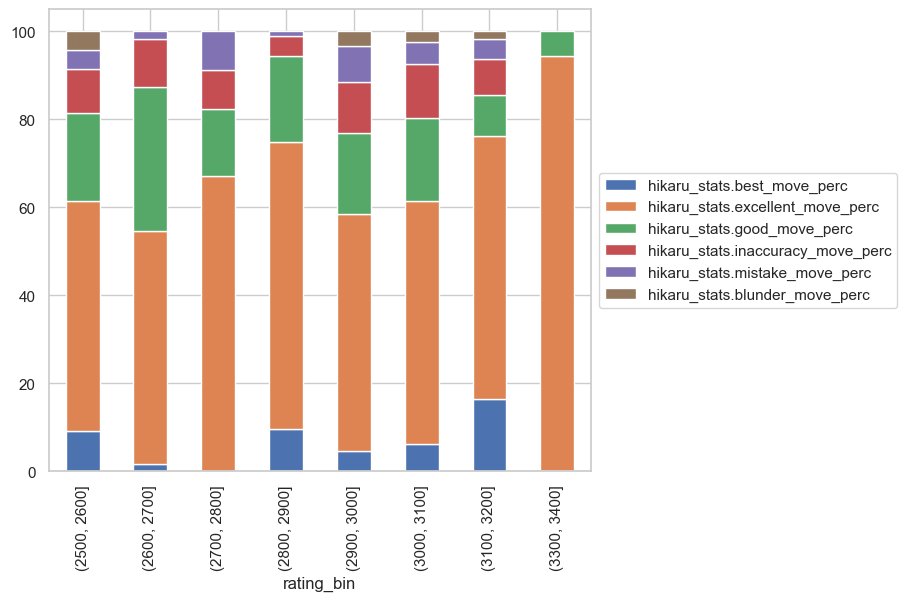

In [41]:
df_plt = streak_games_classification_df.set_index('rating_bin').plot(kind='bar', stacked=True, figsize=(7, 6))
df_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We can tell that, as for the top 2 moves percentage, Hikaru does make good moves >80% of the time which is expected given his expertize. To be honest, I was expecting this number to be even >90%. We can also tell that "interesting" streak games do not deviate from his non streak games, if anything he makes less Best moves which is the best possible option. Let's see these numbers in table

In [42]:
numerical_columns = all_blitz_no_streak_classification_df.select_dtypes(include='number').columns
all_blitz_no_streak_classification_subset_df = all_blitz_no_streak_classification_df.iloc[9:11, :].reset_index(drop=True)
numerical_difference = streak_games_classification_df[numerical_columns] - all_blitz_no_streak_classification_subset_df[numerical_columns]


print(numerical_difference.to_markdown(headers=['Best Move Diff', 'Excellent Move Diff', 'Good Move Diff', 'Inaccuracy Move Diff', 'Mistake Move Diff', 'Blunder Move Diff']))

|    |   Best Move Diff |   Excellent Move Diff |   Good Move Diff |   Inaccuracy Move Diff |   Mistake Move Diff |   Blunder Move Diff |
|---:|-----------------:|----------------------:|-----------------:|-----------------------:|--------------------:|--------------------:|
|  0 |           3.86   |              -6.00896 |         0.957179 |               0.211674 |            -1.04785 |             2.11143 |
|  1 |          -4.3854 |              -4.04416 |        13.8624   |               0.824511 |            -3.47773 |            -2.48553 |
|  2 |         nan      |             nan       |       nan        |             nan        |           nan       |           nan       |
|  3 |         nan      |             nan       |       nan        |             nan        |           nan       |           nan       |
|  4 |         nan      |             nan       |       nan        |             nan        |           nan       |           nan       |
|  5 |         nan      |         

So in "interesting" streak games Hikaru did make less "Best" moves for 1.2% and more excellent moves for 4.8%. If we compare this to top 2 moves percentage statistic we did before what it actually means is that Hikaru in his "interesting" streak games did make less first choice stockfish moves but more second to Nth choice stockfish moves. Also, in general, Hikaru did make less bad moves compared to his other blitz games.

Second row in this table is for range 3000 - 3100 elo range but only for 6 games played therefore not a lot of meaningful analytics can be taken out of it.

So far we saw on how Hikaru played these "interesting" streak games, but let's see how his opponents did play. We'll gather same stats we did for Hikaru for his opponents and what we are interested in is to see if his opponents during streak games did make more bad moves compared to in general opponents.

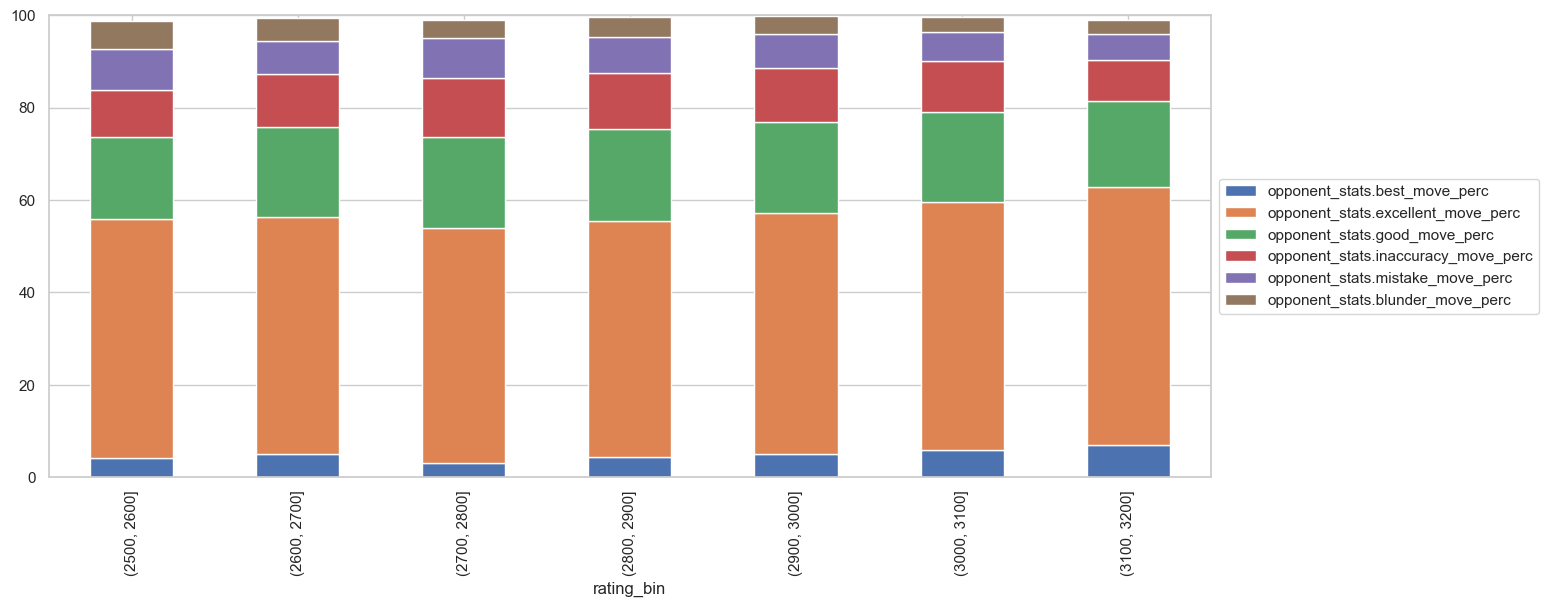

In [43]:
opponent_streak_games_classification_df = streak_games_df.groupby('rating_bin', observed=True).agg({
    'opponent_stats.best_move_perc': 'mean',
    'opponent_stats.excellent_move_perc': 'mean',
    'opponent_stats.good_move_perc': 'mean',
    'opponent_stats.inaccuracy_move_perc': 'mean',
    'opponent_stats.mistake_move_perc': 'mean',
    'opponent_stats.blunder_move_perc': 'mean'
}).reset_index()

opponent_all_blitz_no_streak_classification_df = blitz_180_no_streak_df.groupby('rating_bin', observed=True).agg({
    'opponent_stats.best_move_perc': 'mean',
    'opponent_stats.excellent_move_perc': 'mean',
    'opponent_stats.good_move_perc': 'mean',
    'opponent_stats.inaccuracy_move_perc': 'mean',
    'opponent_stats.mistake_move_perc': 'mean',
    'opponent_stats.blunder_move_perc': 'mean'
}).reset_index()


df_plt = opponent_all_blitz_no_streak_classification_df.set_index('rating_bin').plot(kind='bar', stacked=True, figsize=(15, 6))
df_plt.axis([4.5, 11.5, 0, 100])
df_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

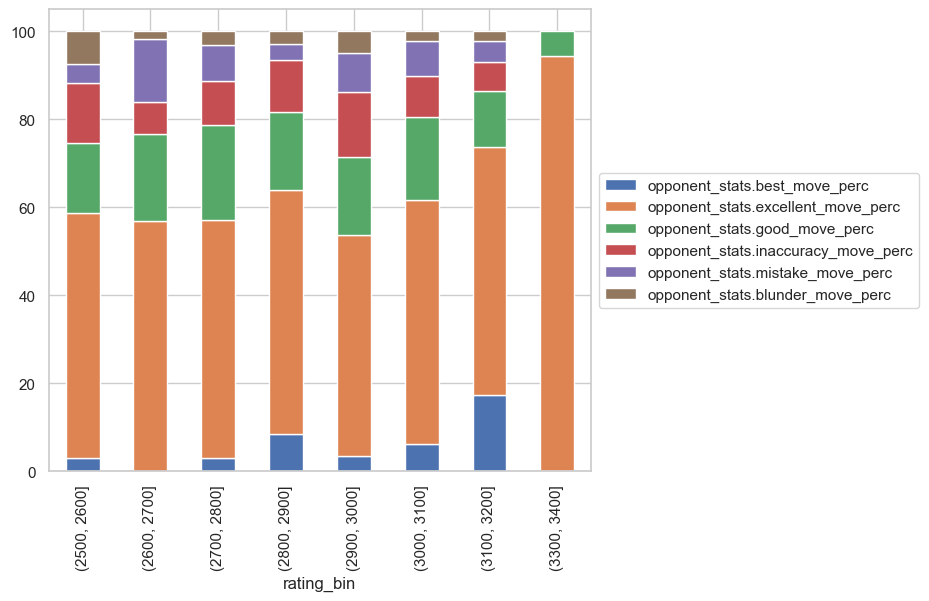

In [44]:
opponent_df_plt = opponent_streak_games_classification_df.set_index('rating_bin').plot(kind='bar', stacked=True, figsize=(7, 6))
opponent_df_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [45]:
opponent_numerical_columns = opponent_all_blitz_no_streak_classification_df.select_dtypes(include='number').columns
opponent_all_blitz_no_streak_classification_subset_df = opponent_all_blitz_no_streak_classification_df.iloc[9:11, :].reset_index(drop=True)
opponent_numerical_difference = opponent_streak_games_classification_df[opponent_numerical_columns] - opponent_all_blitz_no_streak_classification_subset_df[opponent_numerical_columns]


print(opponent_numerical_difference.to_markdown(headers=['Best Move Diff', 'Excellent Move Diff', 'Good Move Diff', 'Inaccuracy Move Diff', 'Mistake Move Diff', 'Blunder Move Diff']))

|    |   Best Move Diff |   Excellent Move Diff |   Good Move Diff |   Inaccuracy Move Diff |   Mistake Move Diff |   Blunder Move Diff |
|---:|-----------------:|----------------------:|-----------------:|-----------------------:|--------------------:|--------------------:|
|  0 |         -1.93812 |               3.41552 |        -3.84175  |                2.1142  |            -3.15676 |             3.57386 |
|  1 |         -5.88426 |               3.11642 |         0.328065 |               -3.71807 |             7.95351 |            -1.50154 |
|  2 |        nan       |             nan       |       nan        |              nan       |           nan       |           nan       |
|  3 |        nan       |             nan       |       nan        |              nan       |           nan       |           nan       |
|  4 |        nan       |             nan       |       nan        |              nan       |           nan       |           nan       |
|  5 |        nan       |         

As expected, we can see that Hikaru's opponents in "interesting" streak games did make less good moves and a slightly more bad moves. In good moves category, they did more good moves which leads to evaluation loss in between 0.02 - 0.05 and did much less excellent and best moves which give better chances in game and leads to better situation. In bad moves category, they did less inaccurate moves (which is the best category in bad) and did a slightly more mistake and blunder moves.

In general all of this seems to align with what GM Hikaru Nakamura is saying about cherry-picking his opponents. Apparently these opponents do play slightly worse then the rest of the opponents Hikaru played against in same rating bucket and Hikaru is able to play better against them compared to the others. 

Let's go back to Hikaru's stats and see average thinking time per move classification.

|    | Opponent range   |   Best Move Avg |   Excellent Move Avg |   Good Move Avg |   Inaccuracy Move Avg |   Mistake Move Avg |   Blunder Move Avg |
|---:|:-----------------|----------------:|---------------------:|----------------:|----------------------:|-------------------:|-------------------:|
|  5 | (2500, 2600]     |        0.74219  |              1.73003 |         2.18946 |               2.29959 |            2.07998 |            2.18124 |
|  6 | (2600, 2700]     |        0.613577 |              2.13853 |         2.421   |               2.72779 |            2.64414 |            1.85823 |
|  7 | (2700, 2800]     |        0.629292 |              2.3722  |         2.95495 |               3.46898 |            2.71481 |            1.82705 |
|  8 | (2800, 2900]     |        0.965927 |              2.65689 |         3.45841 |               3.56333 |            3.53372 |            1.959   |
|  9 | (2900, 3000]     |        0.965101 |              2.79171 |         3.67109 |          

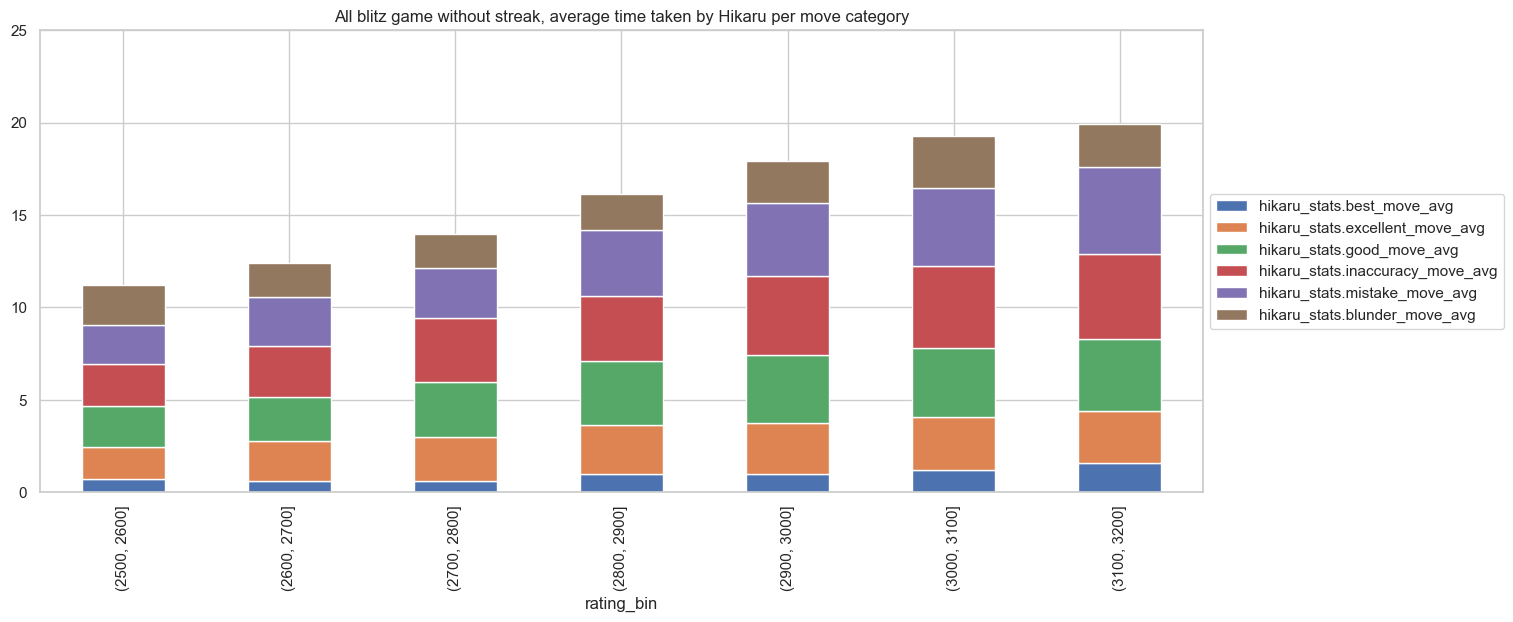

In [46]:
streak_games_time_classification_df = streak_games_df.groupby('rating_bin', observed=True).agg({
    'hikaru_stats.best_move_avg': 'mean',
    'hikaru_stats.excellent_move_avg': 'mean',
    'hikaru_stats.good_move_avg': 'mean',
    'hikaru_stats.inaccuracy_move_avg': 'mean',
    'hikaru_stats.mistake_move_avg': 'mean',
    'hikaru_stats.blunder_move_avg': 'mean'
}).reset_index()

all_blitz_no_streak_time_classification_df = blitz_180_no_streak_df.groupby('rating_bin', observed=True).agg({
    'hikaru_stats.best_move_avg': 'mean',
    'hikaru_stats.excellent_move_avg': 'mean',
    'hikaru_stats.good_move_avg': 'mean',
    'hikaru_stats.inaccuracy_move_avg': 'mean',
    'hikaru_stats.mistake_move_avg': 'mean',
    'hikaru_stats.blunder_move_avg': 'mean'
}).reset_index()

df_plt = all_blitz_no_streak_time_classification_df.set_index('rating_bin').plot(kind='bar', stacked=True, figsize=(15, 6))
df_plt.axis([4.5, 11.5, 0, 25])
df_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
df_plt.set_title('All blitz game without streak, average time taken by Hikaru per move category')

print(all_blitz_no_streak_time_classification_df.iloc[5:12, :].to_markdown(headers=['Opponent range', 'Best Move Avg', 'Excellent Move Avg', 'Good Move Avg', 'Inaccuracy Move Avg', 'Mistake Move Avg', 'Blunder Move Avg']))

From above, we can see that Hikaru spends more time thinking and playing bad moves compared to good moves which is something we also noticed when we were evaluation some of the games in 'On win' section. Also, there seems to be correlation between opponent rating range and Hikaru's thinking time on moves. As Hikaru's opponent rating increases also does his thinking time.
 
 Let's now compare these stats to "interesting" streak games and see if there is any difference in taking good/bad moves in these games compared to all blitz games.

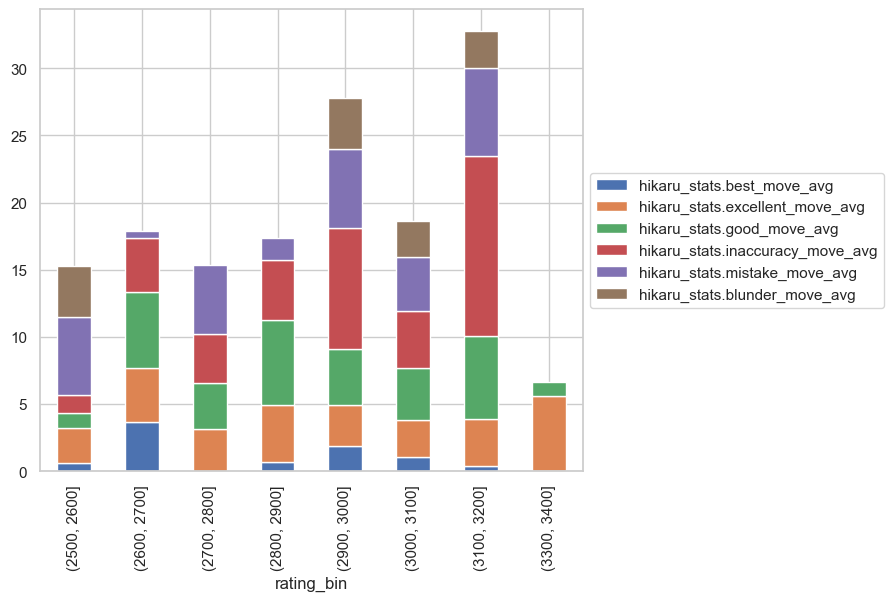

In [47]:
df_plt = streak_games_time_classification_df.set_index('rating_bin').plot(kind='bar', stacked=True, figsize=(7, 6))
df_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [48]:
numerical_columns = all_blitz_no_streak_time_classification_df.select_dtypes(include='number').columns
all_blitz_no_streak_time_classification_subset_df = all_blitz_no_streak_time_classification_df.iloc[9:11, :].reset_index(drop=True)
numerical_difference = streak_games_time_classification_df[numerical_columns] - all_blitz_no_streak_time_classification_subset_df[numerical_columns]


print(numerical_difference.to_markdown(headers=['Best Move Diff', 'Excellent Move Diff', 'Good Move Diff', 'Inaccuracy Move Diff', 'Mistake Move Diff', 'Blunder Move Diff']))

|    |   Best Move Diff |   Excellent Move Diff |   Good Move Diff |   Inaccuracy Move Diff |   Mistake Move Diff |   Blunder Move Diff |
|---:|-----------------:|----------------------:|-----------------:|-----------------------:|--------------------:|--------------------:|
|  0 |        -0.365101 |             -0.175041 |         -2.537   |              -2.97175  |             1.88638 |             1.50995 |
|  1 |         2.46667  |              1.18579  |          1.89017 |              -0.465771 |            -3.6447  |            -2.82158 |
|  2 |       nan        |            nan        |        nan       |             nan        |           nan       |           nan       |
|  3 |       nan        |            nan        |        nan       |             nan        |           nan       |           nan       |
|  4 |       nan        |            nan        |        nan       |             nan        |           nan       |           nan       |
|  5 |       nan        |         

These numbers do not deviate a lot from 0 and given they're in seconds I do not see anything "interesting" in average time taken by move. 
<br>

So far we looked at overall games statistic. Remember that we also gathered these as per game phase, so we can see differences between endgame and middlegame stats.

In [49]:
for phase in ['middlegame', 'endgame']:
    
    streak_games_phase_classification_df = streak_games_df.groupby('rating_bin', observed=True).agg({
        f'hikaru_stats.best_{phase}_move_perc': 'mean',
        f'hikaru_stats.excellent_{phase}_move_perc': 'mean',
        f'hikaru_stats.good_{phase}_move_perc': 'mean',
        f'hikaru_stats.inaccuracy_{phase}_move_perc': 'mean',
        f'hikaru_stats.mistake_{phase}_move_perc': 'mean',
        f'hikaru_stats.blunder_{phase}_move_perc': 'mean'
    }).reset_index()
    
    
    all_blitz_no_streak_phase_classification_df = blitz_180_no_streak_df.groupby('rating_bin', observed=True).agg({
        f'hikaru_stats.best_{phase}_move_perc': 'mean',
        f'hikaru_stats.excellent_{phase}_move_perc': 'mean',
        f'hikaru_stats.good_{phase}_move_perc': 'mean',
        f'hikaru_stats.inaccuracy_{phase}_move_perc': 'mean',
        f'hikaru_stats.mistake_{phase}_move_perc': 'mean',
        f'hikaru_stats.blunder_{phase}_move_perc': 'mean'
    }).reset_index()
    
    
    numerical_columns = all_blitz_no_streak_phase_classification_df.select_dtypes(include='number').columns
    all_blitz_no_streak_phase_classification_subset_df = all_blitz_no_streak_phase_classification_df.iloc[9:11, :].reset_index(drop=True)
    numerical_difference = streak_games_phase_classification_df[numerical_columns] - all_blitz_no_streak_phase_classification_subset_df[numerical_columns]
    
    print(f'Differences in move classification percentage for phase {phase}')
    print(numerical_difference.to_markdown(headers=['Best Move Diff', 'Excellent Move Diff', 'Good Move Diff', 'Inaccuracy Move Diff', 'Mistake Move Diff', 'Blunder Move Diff']))
    print('\n')

Differences in move classification percentage for phase middlegame
|    |   Best Move Diff |   Excellent Move Diff |   Good Move Diff |   Inaccuracy Move Diff |   Mistake Move Diff |   Blunder Move Diff |
|---:|-----------------:|----------------------:|-----------------:|-----------------------:|--------------------:|--------------------:|
|  0 |          6.42576 |              -9.05143 |          0.56084 |               0.434656 |            -1.14326 |             2.8569  |
|  1 |         -1.23516 |              -2.88207 |          9.27212 |               1.19651  |            -3.78617 |            -2.27111 |
|  2 |        nan       |             nan       |        nan       |             nan        |           nan       |           nan       |
|  3 |        nan       |             nan       |        nan       |             nan        |           nan       |           nan       |
|  4 |        nan       |             nan       |        nan       |             nan        |           n

Middlegame stats seems to be inline with what we saw overall as Hikaru does make a bit more excellent moves and a bit less of other moves. However, for endgame and specifically for elo rating 3000 - 3100 Hikaru did make 20% more excellent moves in streak compared to all blitz games. This may be interesting, however let's remember that 3000 - 3100 count for only 6 games so lets now see how many excellent endgame moves there was.

In [50]:
print(streak_games_df.groupby('rating_bin', observed=True).agg({
    f'hikaru_stats.excellent_endgame_move_count': 'sum',
}))

              hikaru_stats.excellent_endgame_move_count
rating_bin                                             
(2500, 2600]                                        6.0
(2600, 2700]                                        4.0
(2700, 2800]                                       22.0
(2800, 2900]                                        8.0
(2900, 3000]                                       99.0
(3000, 3100]                                      128.0
(3100, 3200]                                       14.0
(3300, 3400]                                        0.0


As there was 33 excellent engame moves over 6 games in this bucket it is not enough to draw any conclusion as sample size is too small to compare with all blitz games.

So far we have looked at average data on game level, however we could hardly find any unusual patterns across these. The main reason is that majority of the data across features we've looked at is so much dispersed and anything pretty much can be a usual pattern. Now we'll switch off from game level average data to more granular moves data where we'll try to dive narrow into set of features where we'll try to isolate features that do make correlation when calculating feature X. Such correlations should help us find outliers with better precision so we can detect unusual patterns more precisely.

## Moves, deep dive

First we'll start by creating our moves dataframes

In [51]:
for i, row in blitz_180_no_streak_df.iterrows():
    moves = row['moves']
    if isinstance(moves, list):
        for move in moves:
            move['game_uuid'] = row['uuid']
            move['game_url'] = row['url']
            move['rating_bin'] = row['rating_bin']


for i, row in streak_games_df.iterrows():
    moves = row['moves']
    if isinstance(moves, list):
        for move in moves:
            move['game_uuid'] = row['uuid']
            move['game_url'] = row['url']
            move['rating_bin'] = row['rating_bin']
            
blitz_180_no_streak_moves_df = pd.json_normalize(blitz_180_no_streak_df.explode('moves')['moves'])
streak_games_moves_df = pd.json_normalize(streak_games_df.explode('moves')['moves'])

rating_interval = [pd.Interval(2900, 3000), pd.Interval(3000, 3100)]

#Filter Hikaru moves only and for opponent interval of interest
blitz_180_no_streak_moves_df = blitz_180_no_streak_moves_df.query('player == "Hikaru" & rating_bin in @rating_interval')
streak_games_moves_df = streak_games_moves_df.query('player == "Hikaru"')


### Move time durations

Let's start by checking the average duration of moves that are not in opening phase and distribution of time took per move.

In [52]:
no_opening_moves_180_blitz_df = blitz_180_no_streak_moves_df.query('phase != "OPENING"')
no_opening_moves_180_blitz_df['time_took'].describe()

count    71544.000000
mean         2.963970
std          4.250511
min          0.100000
25%          0.600000
50%          1.400000
75%          3.600000
max         96.800000
Name: time_took, dtype: float64

In [53]:
no_opening_moves_streak_df = streak_games_moves_df.query('phase != "OPENING"')
no_opening_moves_streak_df['time_took'].describe()

count    1666.000000
mean        3.460144
std         5.622557
min         0.100000
25%         0.600000
50%         1.350000
75%         4.000000
max        63.300000
Name: time_took, dtype: float64

We can tell that in general moves taken in blitz game are similar to moves made in streak games from perspective of time took. Streak games moves in average took 0.11 seconds and standard deviation is for 0.6 higher making streak games a bit more disperse. Let's try to isolate moves from streak games that are not within two standard deviation of non streak games and check whether these do have any interesting characteristics.

<br><br>

#### Moves that took longer time to play

In [54]:
std = no_opening_moves_180_blitz_df['time_took'].std()
mean = no_opening_moves_180_blitz_df['time_took'].mean()


moves_not_within_std = no_opening_moves_streak_df[(no_opening_moves_streak_df['time_took'] < mean - 2 *std) | (no_opening_moves_streak_df['time_took'] > mean + 2 * std)]
moves_not_within_std.sort_values('time_took', ascending=False)['time_took'].describe()

count    110.000000
mean      19.929091
std       10.093956
min       11.500000
25%       13.025000
50%       15.800000
75%       21.775000
max       63.300000
Name: time_took, dtype: float64

Apparently there are 74 moves that are outside two standard deviation in streak games. Two standard deviation means that it is outside of 95% of other moves that are already filtered by not being in opening phase. Let's now see how many per games we do have.


In [55]:
moves_not_within_std.groupby('game_url')['game_url'].value_counts().sort_values(ascending=False)

game_url
https://www.chess.com/game/live/94325574257    5
https://www.chess.com/game/live/94349572811    5
https://www.chess.com/game/live/94347098175    5
https://www.chess.com/game/live/94327922509    4
https://www.chess.com/game/live/94087881223    4
https://www.chess.com/game/live/94348380945    4
https://www.chess.com/game/live/94410765399    4
https://www.chess.com/game/live/94410248093    4
https://www.chess.com/game/live/94321378147    4
https://www.chess.com/game/live/94321996121    4
https://www.chess.com/game/live/94326192045    4
https://www.chess.com/game/live/94348971501    3
https://www.chess.com/game/live/94347704737    3
https://www.chess.com/game/live/94345880895    3
https://www.chess.com/game/live/94408955119    3
https://www.chess.com/game/live/94328530879    3
https://www.chess.com/game/live/94412052023    3
https://www.chess.com/game/live/94409058069    3
https://www.chess.com/game/live/94408319023    3
https://www.chess.com/game/live/94409549263    3
https://www

There are 38 games that have such moves where game with most such moves had 5 of them. Let's now compare this to non streak games. Basically we want to see what is average count of such moves per game in non streak games and compare them to these. This may tell us if Hikaru's thinking time was off compared to non streak games.

In [56]:
moves_blitz_180_not_within_std = no_opening_moves_180_blitz_df[(no_opening_moves_180_blitz_df['time_took'] < mean - 2 *std) | (no_opening_moves_180_blitz_df['time_took'] > mean + 2 * std)]
moves_blitz_180_not_within_std.groupby('game_url')['game_url'].value_counts().describe()

count    1511.000000
mean        2.140304
std         1.075389
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: count, dtype: float64

In [57]:
moves_not_within_std.groupby('game_url')['game_url'].value_counts().describe()

count    39.000000
mean      2.820513
std       1.189246
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       5.000000
Name: count, dtype: float64

Simply checking counts of such moves per game does not seem to be unusual where majority of the stats are really close. However, we still want to use these moves and compare some other features of them such as what is percentage of good moves per game and bad moves out of these. First we'll start by converting all of our flags of interest into numerical values so we can calculate these statistics easier.

In [58]:
# First lets convert our boolean flags to numbers 1 in case of true or 0 in case of false
columns_to_convert = ['eval_flags.good', 'eval_flags.best', 'eval_flags.excellent', 'eval_flags.inaccuracy', 'eval_flags.mistake', 'eval_flags.blunder', 'only_move', 'only_move_candidate',
                      'only_move_on_mistake', 'only_move_advantage', 'missed_only_move', 'only_move_recovery', 'only_move_recovery_turning_point', 'best_move'
                      ]

moves_not_within_std[columns_to_convert] = moves_not_within_std[columns_to_convert].apply(pd.to_numeric, errors='coerce').fillna(value=0)
moves_blitz_180_not_within_std[columns_to_convert] = moves_blitz_180_not_within_std[columns_to_convert].apply(pd.to_numeric, errors='coerce').fillna(value=0)


moves_not_within_std['good_move_p'] = moves_not_within_std['eval_flags.good']  + moves_not_within_std['eval_flags.best']   + moves_not_within_std['eval_flags.excellent'] 
moves_blitz_180_not_within_std['good_move_p'] = moves_blitz_180_not_within_std['eval_flags.good']  + moves_blitz_180_not_within_std['eval_flags.best']   + moves_blitz_180_not_within_std['eval_flags.excellent'] 

moves_not_within_std['bad_move_p'] = moves_not_within_std['eval_flags.inaccuracy']  + moves_not_within_std['eval_flags.mistake']  + moves_not_within_std['eval_flags.blunder'] 
moves_blitz_180_not_within_std['bad_move_p'] = moves_blitz_180_not_within_std['eval_flags.inaccuracy']  + moves_blitz_180_not_within_std['eval_flags.mistake']  + moves_blitz_180_not_within_std['eval_flags.blunder'] 

Now lets check how many of these moves where Hikaru would think more than he usually thinks were actually only moves. This should give us a number which represent how often does Hikaru sense that there is something in position and that he can take advantage of that.

In [59]:
moves_blitz_180_not_within_std[['only_move_candidate']].apply(lambda x: x.value_counts(normalize=True) * 100)

,only_move_candidate
only_move_candidate,
False,72.603587
True,27.396413


In [60]:
moves_not_within_std[['only_move_candidate']].apply(lambda x: x.value_counts(normalize=True) * 100)

,only_move_candidate
only_move_candidate,
False,71.818182
True,28.181818


Now what does this mean is that out of all moves in dataset where Hikaru took more time for thinking (min 11.5 seconds), ~29.7% of the moves in streak games and ~27.3% of moves in none streak games were what we called only moves which are moves after his opponent made a bad move. So for 2.5% more often Hikaru would sense that previous opponent move was a bad move and will take more time to think.

Now lets see how many of these moves were actually taken advantage of.

In [61]:
moves_blitz_180_not_within_std.query('only_move_candidate == True')[['only_move']].apply(lambda x: x.value_counts(normalize=True) * 100)

,only_move
only_move,
False,66.817156
True,33.182844


For non streak games we can tell that this value (33%) is unusually small if we remember that in average Hikaru would take around 50% only moves per game. Apparently the more he thinks the less only moves he will play. Let's now check the streak games.

In [62]:
moves_not_within_std.query('only_move_candidate == True')[['only_move']].apply(lambda x: x.value_counts(normalize=True) * 100)

,only_move
only_move,
False,64.516129
True,35.483871


Well streak games, surprisingly as well, have even lower core than non streak games being 32%. What does this essentially mean is that even though in streak games he would sense only moves more often, less often he would play actually best move in position.

Let's also check how many of the only moves were advantage compared to recovery moves.


In [63]:
moves_blitz_180_not_within_std.query('only_move == True')[['only_move_advantage', 'only_move_recovery', 'only_move_recovery_turning_point']].apply(lambda x: x.value_counts(normalize=True) * 100)

,only_move_advantage,only_move_recovery,only_move_recovery_turning_point
0.0,46.938776,53.061224,78.231293
1.0,53.061224,46.938776,21.768707


So for non streak games we can tell that it is pretty much even. About 50% of only moves were for taking advantage out of draw-ish position as well as about 50% of the moves were for recovery moves where Hikaru was loosing. 22% of the all recovery only moves were made so Hikaru took advantage in evaluation after them. Let's now compare this to streak games

In [64]:
(moves_not_within_std.query('only_move == True')[['only_move_advantage', 'only_move_recovery', 'only_move_recovery_turning_point']].fillna(value=0).apply(lambda x: x.value_counts(normalize=True) * 100))

,only_move_advantage,only_move_recovery,only_move_recovery_turning_point
0.0,72.727273,27.272727,45.454545
1.0,27.272727,72.727273,54.545455


For streak games numbers are much different where 71% of the only moves were for taking advantage and only 28% were for recovery. However, there are only 7 of these moves in streak games so this metric is questionable to compare.

Now we're done with only moves, lets also check the top two moves.

In [65]:
moves_blitz_180_not_within_std[['best_move']].apply(lambda x: x.value_counts(normalize=True) * 100)

,best_move
best_move,
True,54.112554
False,45.887446


So in non streak games 54% of the moves Hikaru played after taking more time to think were best moves. If we revisit our top two moves section from above and compare it to here it is about 20% less than what usually Hikaru would play where the average percentage of top two moves is about 70%. And now for the streak games

In [66]:
moves_not_within_std[['best_move']].apply(lambda x: x.value_counts(normalize=True) * 100)

,best_move
best_move,
True,57.272727
False,42.727273


Well for about 8% less compared to the non streak games. So Hikaru is making more bad moves if he thinks more in streak games compared to all his non streak games. Lets also see in which phase of game majority of these moves have been played.

In [67]:
moves_blitz_180_not_within_std[['phase']].apply(lambda x: x.value_counts(normalize=True) * 100)

,phase
phase,
MIDDLEGAME,94.897959
ENDGAME,5.102041


In [68]:
moves_not_within_std[['phase']].apply(lambda x: x.value_counts(normalize=True) * 100)

,phase
phase,
MIDDLEGAME,95.454545
ENDGAME,4.545455


As expected, the big majority of the moves were played in middleware for both streak and not streak games. 

#### Only moves that took longer time to play

So far we looked at all moves excluding those from opening phase and filtered out those which took longer time to play. Lets now apply same logic but also filter these moves by being only moves to check on if there is anything interesting there.

In [69]:
only_moves_180_blitz_df = blitz_180_no_streak_moves_df.query('phase != "OPENING" & only_move')
only_moves_180_blitz_df['time_took'].describe()

count    6324.000000
mean        3.295810
std         4.005985
min         0.100000
25%         0.900000
50%         1.900000
75%         4.200000
max        41.600000
Name: time_took, dtype: float64

In [70]:
only_moves_streak_df = streak_games_moves_df.query('phase != "OPENING" & only_move')
only_moves_streak_df['time_took'].describe()

count    155.000000
mean       3.912903
std        5.840596
min        0.100000
25%        1.000000
50%        1.700000
75%        4.700000
max       42.100000
Name: time_took, dtype: float64

Just by checking only moves there is barely any difference in time took for these moves. To confirm, lets apply same as above where we'll calculate standard deviation for non streak games and look up for moves in streak games which do not fall in two standard deviations calculated from non streak games.

In [71]:
om_std = only_moves_180_blitz_df['time_took'].std()
om_mean = only_moves_180_blitz_df['time_took'].mean()


only_moves_not_within_std = only_moves_streak_df[(only_moves_streak_df['time_took'] < om_mean - 2 *om_std) | (only_moves_streak_df['time_took'] > om_mean + 2 * om_std)]
only_moves_not_within_std.sort_values('time_took', ascending=False)['time_took'].describe()

count    11.000000
mean     19.972727
std      10.984270
min      11.500000
25%      12.650000
50%      14.300000
75%      22.650000
max      42.100000
Name: time_took, dtype: float64

So there is 7 only moves that are outside two standard deviations calculate above. Let's see these moves and their properties

In [72]:
only_moves_not_within_std

,move,best_move,pieces,phase,playing,player,under_time_pressure,time_took,time_left,game_uuid,...,eval_flags.mistake,missed_only_move,only_move_advantage,wdl_flags.recover_move,wdl_flags.bad_move,wdl_flags.take_advantage_move,only_move_on_mistake,eval_flags.blunder,only_move_on_blunder,only_move_recovery_turning_point
903,c6e5,True,23,MIDDLEGAME,Black,Hikaru,False,17.6,50.2,8b57a267-8888-11ee-9c40-6cfe544c0428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1034,a8c8,True,25,MIDDLEGAME,Black,Hikaru,False,11.7,88.6,8539e6c9-888b-11ee-9c40-6cfe544c0428,...,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1302,c8c7,True,17,MIDDLEGAME,Black,Hikaru,False,12.6,37.2,c09bfbaf-8890-11ee-9c40-6cfe544c0428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1496,f6g4,True,30,MIDDLEGAME,Black,Hikaru,False,22.6,127.1,4647fec5-8892-11ee-9c40-6cfe544c0428,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN
1694,e6g7,True,24,MIDDLEGAME,Black,Hikaru,False,42.1,84.3,fc193966-8895-11ee-9c40-6cfe544c0428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2449,e2c4,True,23,MIDDLEGAME,White,Hikaru,False,22.7,101.9,9c50866c-88c2-11ee-9c40-6cfe544c0428,...,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,True,True
2757,a1h1,True,23,MIDDLEGAME,White,Hikaru,False,39.1,94.7,a61d475f-88c7-11ee-9c40-6cfe544c0428,...,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2895,d6c7,True,18,MIDDLEGAME,Black,Hikaru,False,12.7,53.2,13c2a061-88c9-11ee-9c40-6cfe544c0428,...,NaN,NaN,True,NaN,NaN,True,NaN,NaN,NaN,NaN
2975,f8a3,True,24,MIDDLEGAME,Black,Hikaru,False,12.8,108.1,5ecf0aca-8950-11ee-9c40-6cfe544c0428,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,True,NaN
3685,c5d4,True,28,MIDDLEGAME,Black,Hikaru,False,14.3,124.8,43890531-8956-11ee-9c40-6cfe544c0428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


Now lets hand check some of these moves.

<br>

##### 93977534149 - Game against Pe0la 
https://www.chess.com/analysis/game/live/93977534149

This is a game we also checked above for the same reason. After his opponent made a blunder and moved a move that at first hand does not look like a huge blunder to me (but I'm not good at ches) which is moving a pawn to d4, Hikaru did find best move of capturing a free pawn and giving a check. Up to this situation Hikaru was lost by 2 however, after finding best moves from now on he managed to turn the position and win the game. On this specific move which is queen captures he took ~12 seconds to think which is outside 95% of all only moves in non streak games. It is worth mentioning that after finding recovery move Hikaru did make no more mistakes and went to win the game.

<br>
<img src="data/photos/case5/only-move.png" width="700" height="700" />
<br>
<br>

##### 93903652211 - Game against Artur0208

https://www.chess.com/game/live/93903652211

Second game we'll take a look is a game against Artur0208 where Hikaru did manage to spot a move which leads to a checkmate in 6. While the game itself was draw-ish and both players did make some mistakes, after Hikaru's opponent made a mistake move of moving his rook from a1 to e1, Hikaru did find the only move by moving his rook from f2 to e2 which leads to a non-stoppable checkmate. Similarly to the game above, Hikaru did spend ~12 seconds on thinking before he played this move.

<br>
<img src="data/photos/case6/only-move.png" width="700" height="700" />
<br>
<br>

Now for me, it is hard to tell whether there is anything weird with these moves as in some percentage of moves Hikaru will take more time to think and frankly these moves are more often bad than good. However, these moves are outside 95% by time taken for only moves. 

Let's also check one more thing on only moves. I want to see what is percentage of games out of total in dataset in which Hikaru will take more time when he plays only moves. Given that in streak games we have 7 of these it would be 7/44. We want to see how that percentage compares to all 3+0 games dataset where Hikaru won the game (as streak games were all won).

In [73]:
streak_games_perc = (only_moves_not_within_std.groupby('game_uuid')['game_uuid'].unique().count() / streak_games_df['uuid'].count()) * 100
streak_games_perc

22.727272727272727

In [74]:
only_moves_no_streak_not_within_std = only_moves_180_blitz_df[(only_moves_180_blitz_df['time_took'] < om_mean - 2 * om_std) | (only_moves_180_blitz_df['time_took'] > om_mean + 2 * om_std)]

no_streak_games_perc = (only_moves_no_streak_not_within_std.groupby('game_uuid')['game_uuid'].unique().count() / blitz_180_no_streak_df['uuid'].count()) * 100
no_streak_games_perc


7.571585903083701

Apparently for the streak games in 16% of the games Hikaru did find only moves by taking longer time to think while this percentage for all his other games is 7.5%.
<br>

## Other games and other streaks

So far we have checked and compare streak games to entire other dataset. Moving on, what I want to do is to isolate all streak games during 2023 for blitz 3+0 and check stats on that. Furthermore, we will be comparing this streak to other streaks in dataset.

We will define a streak as a winning games with maximum 1 draw in between as more than 1 draw would affect Hikaru's elo more significantly.

Given that interesting streak games were played in time span of almost 18 hours, we need to apply that filter when making our groups as well. Basically two consecutive games cannot have time difference greater than 18 hours.

In [75]:
filtered_by_180_time_control_df['time_diff'] = filtered_by_180_time_control_df['timestamp'].diff().dt.total_seconds() 

time_threshold = 60 * 60 * 18 #18 hours threshold

group_identifier = (filtered_by_180_time_control_df['time_diff'] > time_threshold).cumsum()

game_groups = {group: group_df.drop(columns=['time_diff']) for group, group_df in filtered_by_180_time_control_df.groupby(group_identifier)}
game_groups = {group: group_df for group, group_df in game_groups.items() if
               len(group_df) >= 20}

len(game_groups)

56

So we have 57 game groups where Hikaru played more than 20 games. Let's start by checking some basic statistics such as average opponent elo and win rate for each group. We will also add information on longest streak within each group.

In [76]:
def find_longest_streak(games):
    current_streak = []
    longest_streak = []
    draw_game_index = None
    
    for index, game in games.iterrows():
        if game['win'] == 100:
            current_streak.append(game)
        elif game['draw'] == 100 and draw_game_index is None:
            draw_game_index = index
            current_streak.append(game)
        elif game['draw'] == 100 and draw_game_index is not None:
            #Check winning streak from last draw game
            inner_games = games.loc[draw_game_index + 1:]
            inner_streak = find_longest_streak(inner_games)
            
            if len(inner_streak) > len(current_streak):
                current_streak = inner_streak
            
            if len(current_streak) > len(longest_streak):
                longest_streak = current_streak
            draw_game_index = None
            current_streak = []
        else:
            if len(current_streak) > len(longest_streak):
                longest_streak = current_streak
            draw_game_index = None
            current_streak = []
            
    if len(current_streak) > len(longest_streak):
        longest_streak = current_streak
    return longest_streak

data = []
for group_id, group_df in game_groups.items():
    start_date = group_df['timestamp'].min().strftime('%Y-%m-%d %H:%M:%S')
    end_date = group_df['timestamp'].max().strftime('%Y-%m-%d %H:%M:%S')
    longest_streak = len(find_longest_streak(group_df))
    game_count = len(group_df)
    lsp = longest_streak/game_count * 100
    opponent_rating = group_df['hikaru_stats.opponent_rating'].mean()
    win_rate = group_df['win'].mean()
    draw_rate = group_df['draw'].mean()
    loose_rate = group_df['loose'].mean()
    
    data.append({
        'Group id': group_id,
        'Game count': game_count,
        'Longest streak': longest_streak,
        'Longest streak %': lsp,
        'Average Opponent Rating': opponent_rating,
        'Win %': win_rate,
        'Draw %': draw_rate,
        'Loose %': loose_rate,
        'Start': start_date,
        'End': end_date
    })

basic_stats_df = pd.DataFrame(data, columns=['Group id', 'Game count', 'Longest streak', 'Longest streak %', 'Average Opponent Rating', 'Win %', 'Draw %', 'Loose %', 'Start', 'End'])
basic_stats_df.sort_values(by='Longest streak', ascending=False)

,Group id,Game count,Longest streak,Longest streak %,Average Opponent Rating,Win %,Draw %,Loose %,Start,End
20,44,191,69,36.125654,2624.256545,88.481675,6.282723,5.235602,2023-05-02 20:24:59,2023-05-06 13:35:13
39,86,94,55,58.510638,2823.648936,88.297872,5.319149,6.382979,2023-09-26 23:41:28,2023-09-29 15:38:20
48,99,126,49,38.888889,2818.976190,86.507937,3.968254,9.523810,2023-11-22 16:06:58,2023-11-24 18:21:29
47,97,61,46,75.409836,2983.934426,86.885246,4.918033,8.196721,2023-11-16 18:48:18,2023-11-17 21:28:45
53,106,51,34,66.666667,2937.411765,84.313725,13.725490,1.960784,2023-12-14 16:16:05,2023-12-15 19:22:21
19,43,47,31,65.957447,1589.255319,93.617021,2.127660,2.127660,2023-05-01 12:02:13,2023-05-01 14:27:15
55,108,63,30,47.619048,2810.920635,88.888889,7.936508,3.174603,2023-12-26 13:51:14,2023-12-27 18:57:47
36,77,38,30,78.947368,2899.947368,97.368421,0.000000,2.631579,2023-08-25 13:15:14,2023-08-25 17:57:36
45,95,56,29,51.785714,2951.517857,87.500000,5.357143,7.142857,2023-11-13 13:59:45,2023-11-13 20:14:28
24,53,238,29,12.184874,2908.042017,77.731092,7.983193,13.865546,2023-06-13 12:32:22,2023-06-16 20:36:10


So here we can see some "interesting" stats. Even though after making his interesting streak Hikaru did make some more streaks with even higher streak wins, in his "interesting" streak games the percentage of streak games compared to all the games in a group is the highest if we look at the streaks with more than 30 games played. In "interesting" streak games make 75% of all games played in group. For comparison two other streaks where he made 69, 49 and 55 wins he scored  36%, 38% and 58% of the games. Another important take here is that In these two other top scored streak games Hikaru's average opponent rating was much lower about 2620 and 2820 while in his "interesting" streak games his opponents average elo is 2983. 

It is also worth mentioning that before "interesting" streak games and after Hikaru did manage to score even better making 27/27 wins with one draw however, games count is much lower.

While this may seem interesting and worth checking, it is important to say that we did split games into groups having in mind "interesting" streak games and time span in which they were played which is 18 hours of difference. To be honest, to me such a big difference do not make sense and I would put it to maximum 6 hours as I feel like 6 hours is enough time to reset the streak. Let's now plot the streak games, so we can see how Hikaru made these streaks over 2023.

For the time being we will stick to these groups and next thing we want to see is these streaks over time and how did they happen.


Text(0.5, 1.0, 'Count of Streaks over time')

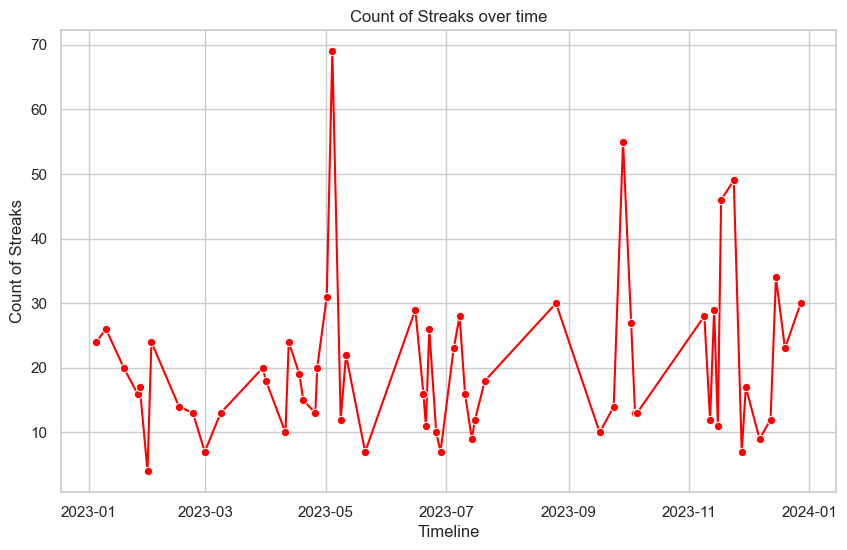

In [77]:
data = []
for group_id, group_df in game_groups.items():
    longest_streak = len(find_longest_streak(group_df))
    game_count = len(group_df)
    lsp = longest_streak/game_count * 100
    
    data.append({
        'Group id': group_id,
        'Streak count': longest_streak,
        'streak_perc': lsp,
        'date': group_df['timestamp'].mean()
    })

plot_df = pd.DataFrame(data, columns=['Group id', 'Streak count', 'streak_perc', 'date'])
plt.figure(figsize=(10, 6))

sns.lineplot(x='date', y='Streak count', data=plot_df, marker='o', linestyle='-', color='red')

plt.xlabel('Timeline')
plt.ylabel('Count of Streaks')
plt.title('Count of Streaks over time')

We can tell that these big streaks did happen in a later part of the year with the exception of a game group #44 which did happen in May. while in the first part he still did make streaks which did have counts > 20. 
Let's see the same thing for percentage of streak games out of all group games.

<Axes: xlabel='date', ylabel='streak_perc'>

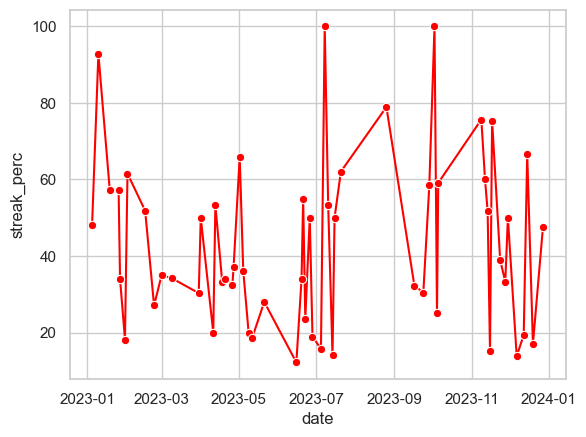

In [78]:
sns.lineplot(x='date', y='streak_perc', data=plot_df, marker='o', linestyle='-', color='red')


Percentage of streak games compared to all games does show that in second part of the year Hikaru did do better in making more streak games out of total games played in a group of games. All of this is indicator to us to check the Hikaru's performance comparing first and second part of 2023.

Before proceeding with these groups I want to confirm what we see so far and that is in later part of the year Hikaru did make more streaks comparing to the first part of the year. We will extract all possible streak games that are longer than 5 games and plot them now.

230


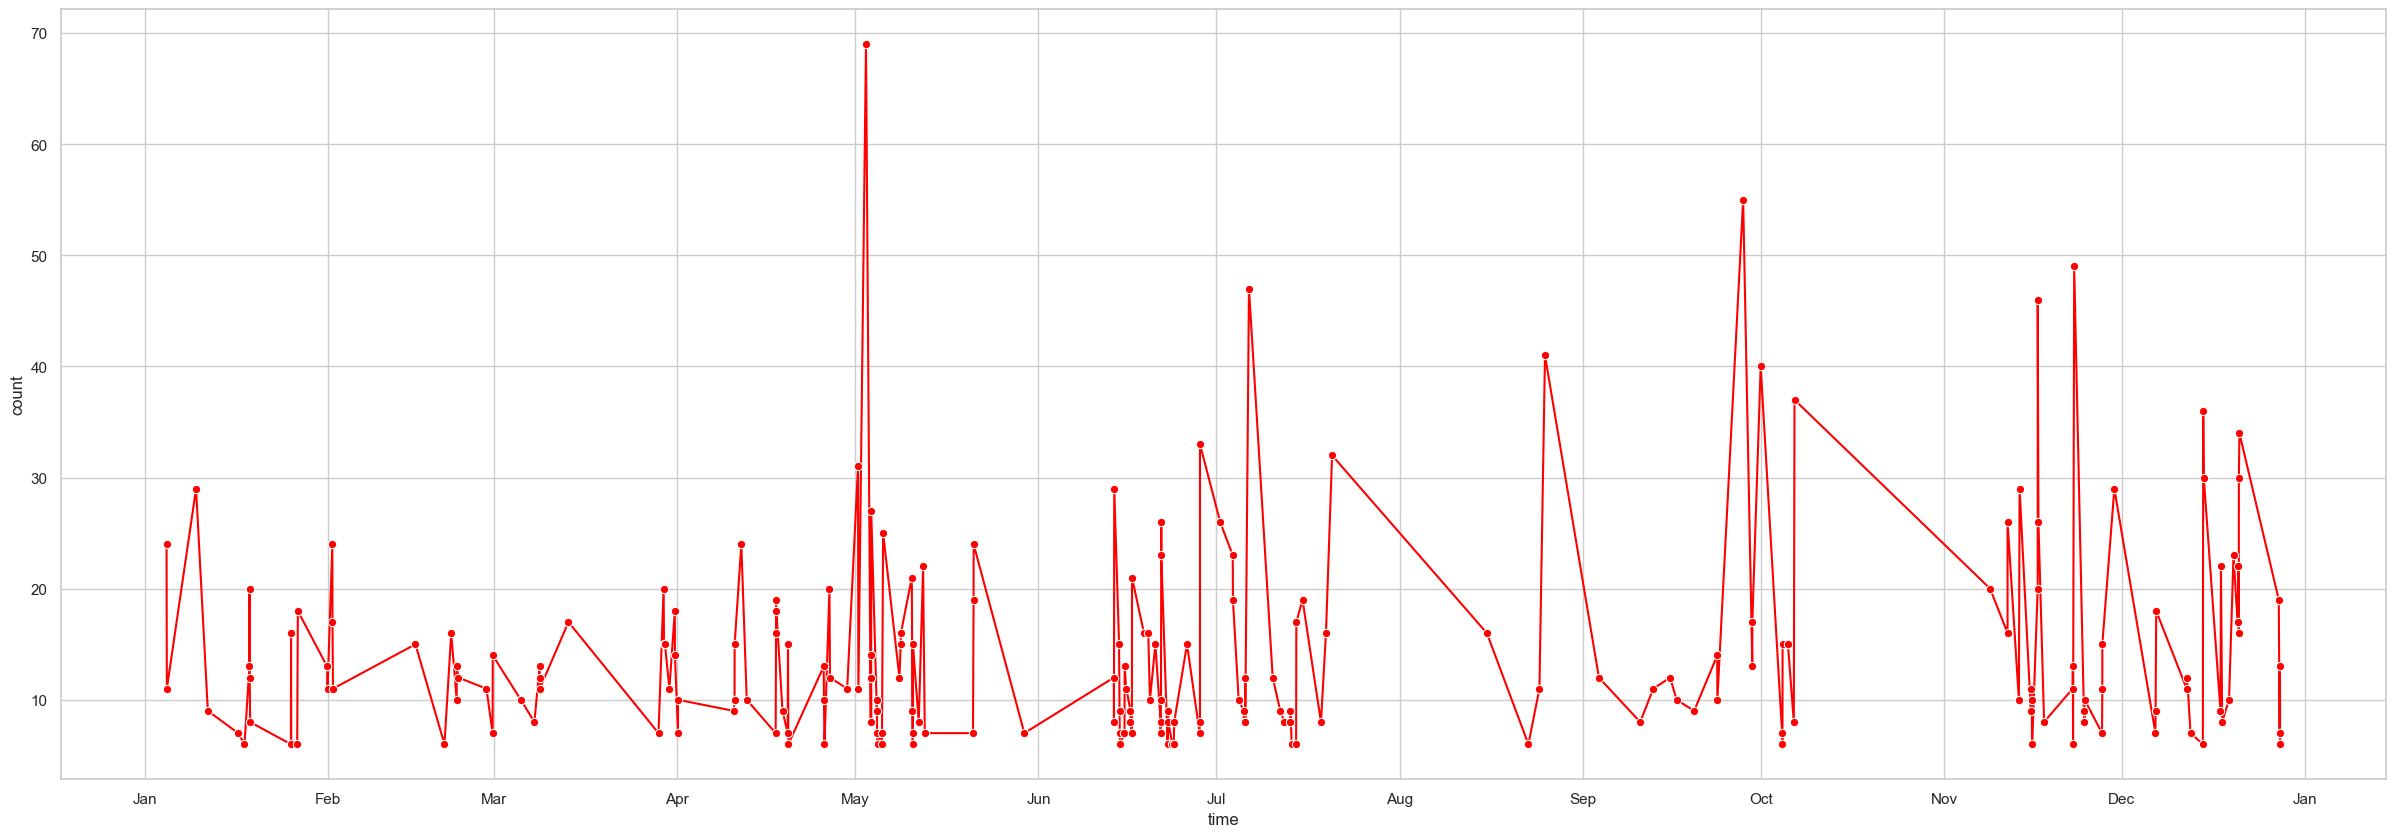

In [79]:
import matplotlib.dates as mdates

STREAK_MIN_LENGTH = 5

def find_streaks(games):
    current_streak = []
    streaks = []
    draw_game_index = None
    
    for index, game in games.iterrows():
        if game['win'] == 100:
            current_streak.append(game)
        elif game['draw'] == 100 and draw_game_index is None:
            draw_game_index = index
            current_streak.append(game)
        elif game['draw'] == 100 and draw_game_index is not None:
            #Check winning streak starting from last draw game
            inner_games = games.loc[draw_game_index + 1:]
            inner_streak = find_next_streak(inner_games)
            
            if len(inner_streak) > STREAK_MIN_LENGTH:
                streaks.append(inner_streak)
            
            if len(current_streak) > STREAK_MIN_LENGTH:
                streaks.append(current_streak)
            draw_game_index = None
            current_streak = []
        else:
            if len(current_streak) > STREAK_MIN_LENGTH:
                streaks.append(current_streak)
            draw_game_index = None
            current_streak = []
            
    if len(current_streak) > STREAK_MIN_LENGTH:
        streaks.append(current_streak)
    return streaks

def find_next_streak(games):
    current_streak = []
    draw_game_index = None
    
    for index, game in games.iterrows():
        if game['win'] == 100:
            current_streak.append(game)
        elif game['draw'] == 100 and draw_game_index is None:
            draw_game_index = index
            current_streak.append(game)
        else:
            break
    return current_streak

all_streaks = find_streaks(filtered_by_180_time_control_df)
print(len(all_streaks))

data = []
for streak in all_streaks:
    start_date = streak[0]['timestamp']
    count = len(streak)
    data.append({
        'time': start_date,
        'count': count
    })

basic_stats_df = pd.DataFrame(data, columns=['time', 'count'])
plt.figure(figsize=(30, 10))

ax = sns.lineplot(x='time', y='count', data=basic_stats_df, marker='o', linestyle='-', color='red')
# Customize the x-axis date formatting
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # %b for abbreviated month name

We can tell that same behaviour is sort of present by looking at all possible streak games without time bounds. We do have one streak which is the biggest one actually, and it is in first part of the year however, we can see a trend of streak game counts increasing as time goes by.

Next is to add common statistics we have extracted in our analysis before to each group and compare the data. Essentially what we want to see is if the group of games which holds the "interesting" streak games do deviate in these stats as well.


In [80]:
data = []
for group_id, group_df in game_groups.items():
    longest_streak = len(find_longest_streak(group_df))
    game_count = len(group_df)
    lsp = longest_streak/game_count * 100
    unique_opponents = group_df['hikaru_stats.opponent_username'].nunique()
    
    data.append({
        'Group id': group_id,
        'Game count': game_count,
        'Longest streak': longest_streak,
        'Longest streak %': lsp,
        'Avg opponent rating': group_df['hikaru_stats.opponent_rating'].mean(),
        'Timeout win %' : group_df['timeout_win'].mean(),
        'Top two moves %': group_df['hikaru_stats.top_2_move_perc'].mean(),
        'Top two moves avg time': group_df['hikaru_stats.top_2_move_avg'].mean(),
        'Only moves %': group_df['hikaru_stats.only_move_relative_perc'].mean(),
        'Only moves avg time': group_df['hikaru_stats.only_move_avg'].mean(),
        'Opponent bad moves %': group_df['opponent_stats.bad_moves_perc_sum'].mean(),
        'Win when L>1': group_df['win1'].mean(),
        'Win when L>2': group_df['win2'].mean(),
        'Win when L>3': group_df['win3'].mean(),
        'Win when L>4': group_df['win4'].mean(),
        'Win when L>5': group_df['win5'].mean(),
        'unique_opponents': unique_opponents

    })

basic_stats_df = pd.DataFrame(data, columns=['Group id', 'Game count', 'Longest streak', 'Longest streak %', 'Avg opponent rating','Timeout win %', 'Top two moves %' ,'Top two moves avg time', 'Only moves %', 'Only moves avg time', 'Opponent bad moves %', 'Win when L>1', 'Win when L>2', 'Win when L>3', 'Win when L>4', 'Win when L>5', 'unique_opponents'])
basic_stats_df.sort_values(by='Longest streak', ascending=False)

,Group id,Game count,Longest streak,Longest streak %,Avg opponent rating,Timeout win %,Top two moves %,Top two moves avg time,Only moves %,Only moves avg time,Opponent bad moves %,Win when L>1,Win when L>2,Win when L>3,Win when L>4,Win when L>5,unique_opponents
20,44,191,69,36.125654,2624.256545,12.565445,66.003920,2.494541,48.674941,2.774015,23.294571,48.167539,31.937173,24.607330,21.465969,14.659686,56
39,86,94,55,58.510638,2823.648936,6.382979,70.048694,2.591577,47.420788,2.946955,24.478065,48.936170,29.787234,20.212766,15.957447,13.829787,9
48,99,126,49,38.888889,2818.976190,8.730159,72.015071,2.811157,52.664784,3.168015,25.244118,43.650794,17.460317,11.904762,10.317460,7.936508,40
47,97,61,46,75.409836,2983.934426,13.114754,72.340063,3.047731,55.613624,3.308320,22.932754,47.540984,26.229508,21.311475,14.754098,8.196721,7
53,106,51,34,66.666667,2937.411765,5.882353,71.729322,2.571128,56.748527,3.145165,26.235127,37.254902,13.725490,5.882353,3.921569,0.000000,11
19,43,47,31,65.957447,1589.255319,2.127660,52.355653,2.128186,33.688853,1.808227,21.800369,48.936170,44.680851,38.297872,34.042553,23.404255,31
55,108,63,30,47.619048,2810.920635,7.936508,73.784504,2.720451,50.332538,3.562846,26.523846,42.857143,19.047619,15.873016,12.698413,7.936508,28
36,77,38,30,78.947368,2899.947368,13.157895,72.934219,3.270989,48.738459,3.917632,24.228509,34.210526,21.052632,18.421053,15.789474,10.526316,5
45,95,56,29,51.785714,2951.517857,10.714286,71.696013,3.079763,47.133716,3.305783,26.130919,46.428571,23.214286,16.071429,14.285714,5.357143,4
24,53,238,29,12.184874,2908.042017,5.042017,72.287479,2.765365,49.207438,3.145557,23.720841,39.495798,20.588235,13.445378,11.764706,7.983193,41


What we can tell from table above is that indeed game group 97 did slightly better performance comparing to other top 3 groups. Hikaru did make a slightly more only moves and in average he was taking slightly more time when making these. What is interesting is that in game group 97 Hikaru's opponents did actually make less mistakes comparing to other two which is surprising.

### Regression model

Let's now build a regression model which will predict count of streak games taking as an input other variables such as total count of games, % of only moves and so on. What we want to see is how other variables in our dataset affect streak games count.

In [81]:
opponents_df = filtered_by_180_time_control_df.groupby('hikaru_stats.opponent_username').agg(
    {
        'win': 'mean',
        'loose': 'mean',
        'draw': 'mean'
    }
)

data = []
for group_id, group_df in game_groups.items():
    longest_streak = len(find_longest_streak(group_df))
    game_count = len(group_df)
    lsp = longest_streak/game_count * 100
    unique_opponents = group_df['hikaru_stats.opponent_username'].unique()
    unique_opponents_count = group_df['hikaru_stats.opponent_username'].nunique()

    hikaru_v_opponent_aggs = opponents_df.loc[opponents_df.index.isin(unique_opponents)].agg({
        'win': 'mean',
        'loose': 'mean',
        'draw': 'mean'
    })

    data.append({
        'Group id': group_id,
        'Longest streak': longest_streak,
        'Longest streak %': lsp,
        'Game count': game_count,
        'Avg opponent rating': group_df['hikaru_stats.opponent_rating'].mean(),
        'Timeout win %' : group_df['timeout_win'].mean(),
        'Top two moves %': group_df['hikaru_stats.top_2_move_perc'].mean(),
        'Top two moves avg time': group_df['hikaru_stats.top_2_move_avg'].mean(),
        'Only moves %': group_df['hikaru_stats.only_move_relative_perc'].mean(),
        'Only moves avg time': group_df['hikaru_stats.only_move_avg'].mean(),
        'Opponent bad moves %': group_df['opponent_stats.bad_moves_perc_sum'].mean(),
        'Opponent Top two moves avg time': group_df['opponent_stats.top_2_move_avg'].mean(),
        'Opponent Top two moves %': group_df['hikaru_stats.top_2_move_perc'].mean(),
        'Win when L>1': group_df['win1'].mean(),
        'Win when L>2': group_df['win2'].mean(),
        'Win when L>3': group_df['win3'].mean(),
        'Win when L>4': group_df['win4'].mean(),
        'Win when L>5': group_df['win5'].mean(),
        'unique_opponents': unique_opponents_count,
        'opponent_v_hikaru_performance': hikaru_v_opponent_aggs['loose'],
        'hikaru_v_performance': hikaru_v_opponent_aggs['win'],
        'drawability': hikaru_v_opponent_aggs['draw']

    })

regression_df = pd.DataFrame(data, columns=['Group id', 'Longest streak', 'Longest streak %', 'Game count', 'Avg opponent rating','Timeout win %', 'Top two moves %' ,'Top two moves avg time', 'Only moves %', 'Only moves avg time', 'Opponent bad moves %', 'Opponent Top two moves avg time', 'Opponent Top two moves %', 'Win when L>1', 'Win when L>2', 'Win when L>3', 'Win when L>4', 'Win when L>5', 'unique_opponents', 'opponent_v_hikaru_performance', 'hikaru_v_performance', 'drawability'])

In [82]:
import statsmodels.api as sm

## Linear regression of streak games

features = ['Game count',  'Only moves %', 'Opponent Top two moves %', 'Win when L>4',  'opponent_v_hikaru_performance', 'hikaru_v_performance', 'drawability']

# Create and fit the multiple regression model
X = regression_df[features]
y = regression_df['Longest streak']

# Create the model
model = sm.OLS(y, X)

# Fit the model
result = model.fit()

# Display the multiple regression results
print(result.summary())

predictions = result.predict(regression_df[features])
regression_df['Predicted streak'] = predictions
regression_df['predicted_vs_actual_streak_count'] = regression_df['Longest streak'] - regression_df['Predicted streak']
regression_df[['Group id', 'Game count', 'Longest streak', 'Predicted streak', 'predicted_vs_actual_streak_count']].sort_values(by='predicted_vs_actual_streak_count', ascending=False)

                                 OLS Regression Results                                
Dep. Variable:         Longest streak   R-squared (uncentered):                   0.869
Model:                            OLS   Adj. R-squared (uncentered):              0.851
Method:                 Least Squares   F-statistic:                              46.54
Date:                Sun, 14 Jan 2024   Prob (F-statistic):                    1.71e-19
Time:                        16:04:50   Log-Likelihood:                         -199.65
No. Observations:                  56   AIC:                                      413.3
Df Residuals:                      49   BIC:                                      427.5
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------

,Group id,Game count,Longest streak,Predicted streak,predicted_vs_actual_streak_count
39,86,94,55,28.393339,26.606661
20,44,191,69,46.235629,22.764371
47,97,61,46,30.715535,15.284465
48,99,126,49,35.285413,13.714587
19,43,47,31,17.908427,13.091573
53,106,51,34,20.986370,13.013630
31,61,28,28,20.655461,7.344539
40,88,27,27,19.928632,7.071368
1,2,28,26,18.951331,7.048669
12,30,36,18,11.035362,6.964638


So after trying several combination of parameters and applying backward elimination these features performed the best in our regression model:


<br>

- Games count in group
- Percentage of only moves
- Percentage of top two moves made by opponent
- Percentage of games won when Hikaru was lost by >4 or more
- Average opponents (in group) win rate against Hikaru
- Average Hikaru's win rate vs opponents in group
- Average draw chance for opponents in group vs Hikaru

<br>

The regression model we managed to build here is not perfect as predicted value vs actual value is off, however we can also see that for quite big chunk of numbers error rate is not huge, and it does perform well as our adjusted R-squared value is 0,851 which does mean our model covers 85.1% of data. Now it is likely that our model can be more fine-tuned with other features that I'm not aware at the moment of doing this analysis to obtain even better results so for the time being we will stick to this one.
<br>

Similarly to what we have seen so far, our "interesting" group is in outliers part of the regression results and in this context Hikaru did over perform in these game groups by the biggest margin. 

<br>

#### On streaks summary
Now in streak analysis we did here we were able to identify streak games GM Kramnik was concerned about as an outlier. Moreover, we also did notice that these significant streaks started happening in second part of the 2023 year which may also be an indicator of "interesting" behaviour. Our regression model identified streak games (group id 97) as outlier where our model prediction was off for 15 games compared to what actually happened.

However, regression model we have here does have a flaws. On first, we do have too many outliers in both over performing and under performing space. This said we likely need one or more unknown features to be added in our regression model to perform a better results, or we need a bigger dataset.

Also, it is fair to mention that we specifically picked 18h as split range for groups given that we looked into "interesting" streak. While this may be good, more natural is to do a split on a time window which in reality does impose mental restart of a person. For this reason we will do this same exercise however, this time we will split games where our period of split will be 6 hours.
<br>

## Streaks on 6 hours split

Let's start by splitting our groups per 6 hours difference.

In [83]:
filtered_by_180_time_control_df['time_diff'] = filtered_by_180_time_control_df['timestamp'].diff().dt.total_seconds() 

time_threshold = 60 * 60 * 6 #18 hours threshold

group_identifier_6 = (filtered_by_180_time_control_df['time_diff'] > time_threshold).cumsum()

game_groups_6 = {group: group_df.drop(columns=['time_diff']) for group, group_df in filtered_by_180_time_control_df.groupby(group_identifier_6)}
game_groups_6 = {group: group_df for group, group_df in game_groups_6.items() if
               len(group_df) >= 20}

len(game_groups_6)


73

So now we have 73 groups, let's plot them to visually inspect the streaks.


Text(0.5, 1.0, 'Count of Streaks over time')

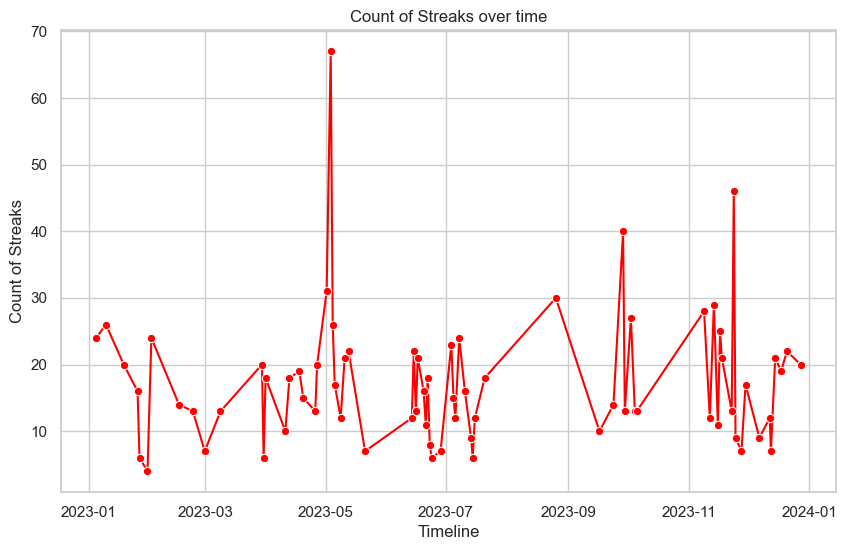

In [84]:
data = []
for group_id, group_df in game_groups_6.items():
    longest_streak = len(find_longest_streak(group_df))
    game_count = len(group_df)
    lsp = longest_streak/game_count * 100
    
    data.append({
        'Group id': group_id,
        'Streak count': longest_streak,
        'streak_perc': lsp,
        'date': group_df['timestamp'].mean()
    })

plot_df = pd.DataFrame(data, columns=['Group id', 'Streak count', 'streak_perc', 'date'])
plt.figure(figsize=(10, 6))

sns.lineplot(x='date', y='Streak count', data=plot_df, marker='o', linestyle='-', color='red')

plt.xlabel('Timeline')
plt.ylabel('Count of Streaks')
plt.title('Count of Streaks over time')

We can tell that similarly to when we splot by 18 hours there is a better performance in second part of the year while the biggest streak games did happen in May. The peaks that we saw in split by 18 hour also seem to be present here in some percentage however it appears to be less. Let's apply regression model and inspect amount of outliers that overlap.

In [85]:
data = []
for group_id, group_df in game_groups_6.items():
    longest_streak = len(find_longest_streak(group_df))
    game_count = len(group_df)
    lsp = longest_streak/game_count * 100
    unique_opponents = group_df['hikaru_stats.opponent_username'].unique()
    unique_opponents_count = group_df['hikaru_stats.opponent_username'].nunique()
    start_date = group_df['timestamp'].min().strftime('%Y-%m-%d %H:%M:%S')
    end_date = group_df['timestamp'].max().strftime('%Y-%m-%d %H:%M:%S')

    hikaru_v_opponent_aggs = opponents_df.loc[opponents_df.index.isin(unique_opponents)].agg({
        'win': 'mean',
        'loose': 'mean',
        'draw': 'mean'
    })

    data.append({
        'Group id': group_id,
        'Longest streak': longest_streak,
        'Longest streak %': lsp,
        'Game count': game_count,
        'Avg opponent rating': group_df['hikaru_stats.opponent_rating'].mean(),
        'Timeout win %' : group_df['timeout_win'].mean(),
        'Top two moves %': group_df['hikaru_stats.top_2_move_perc'].mean(),
        'Top two moves avg time': group_df['hikaru_stats.top_2_move_avg'].mean(),
        'Only moves %': group_df['hikaru_stats.only_move_relative_perc'].mean(),
        'Only moves avg time': group_df['hikaru_stats.only_move_avg'].mean(),
        'Opponent bad moves %': group_df['opponent_stats.bad_moves_perc_sum'].mean(),
        'Opponent Top two moves avg time': group_df['opponent_stats.top_2_move_avg'].mean(),
        'Opponent Top two moves %': group_df['hikaru_stats.top_2_move_perc'].mean(),
        'Win when L>1': group_df['win1'].mean(),
        'Win when L>2': group_df['win2'].mean(),
        'Win when L>3': group_df['win3'].mean(),
        'Win when L>4': group_df['win4'].mean(),
        'Win when L>5': group_df['win5'].mean(),
        'unique_opponents': unique_opponents_count,
        'opponent_v_hikaru_performance': hikaru_v_opponent_aggs['loose'],
        'hikaru_v_performance': hikaru_v_opponent_aggs['win'],
        'drawability': hikaru_v_opponent_aggs['draw'],
        'start_date': start_date,
        'end_date': end_date

    })

regression_6_df = pd.DataFrame(data, columns=['Group id', 'Game count','Longest streak', 'Longest streak %', 'Avg opponent rating', 'start_date', 'end_date', 'Timeout win %', 'Top two moves %' ,'Top two moves avg time', 'Only moves %', 'Only moves avg time', 'Opponent bad moves %', 'Opponent Top two moves avg time', 'Opponent Top two moves %', 'Win when L>1', 'Win when L>2', 'Win when L>3', 'Win when L>4', 'Win when L>5', 'unique_opponents', 'opponent_v_hikaru_performance', 'hikaru_v_performance', 'drawability'])
regression_6_df.sort_values(by='Longest streak', ascending=False)


,Group id,Game count,Longest streak,Longest streak %,Avg opponent rating,start_date,end_date,Timeout win %,Top two moves %,Top two moves avg time,...,Opponent Top two moves %,Win when L>1,Win when L>2,Win when L>3,Win when L>4,Win when L>5,unique_opponents,opponent_v_hikaru_performance,hikaru_v_performance,drawability
21,49,86,67,77.906977,2259.488372,2023-05-03 11:43:39,2023-05-03 17:57:32,8.139535,61.173530,2.084326,...,61.173530,56.976744,41.860465,36.046512,33.720930,23.255814,47,2.978994,91.326752,5.536650
62,134,46,46,100.000000,2777.043478,2023-11-23 15:43:46,2023-11-23 22:09:25,8.695652,73.740033,3.153596,...,73.740033,36.956522,8.695652,6.521739,6.521739,6.521739,7,0.996678,97.586991,1.416332
50,117,40,40,100.000000,2722.000000,2023-09-28 13:38:53,2023-09-28 21:50:49,10.000000,67.006830,2.513111,...,67.006830,57.500000,40.000000,25.000000,25.000000,20.000000,2,0.000000,100.000000,0.000000
20,47,47,31,65.957447,1589.255319,2023-05-01 12:02:13,2023-05-01 14:27:15,2.127660,52.355653,2.128186,...,52.355653,48.936170,44.680851,38.297872,34.042553,23.404255,31,2.009055,93.520091,0.169779
47,105,38,30,78.947368,2899.947368,2023-08-25 13:15:14,2023-08-25 17:57:36,13.157895,72.934219,3.270989,...,72.934219,34.210526,21.052632,18.421053,15.789474,10.526316,5,2.847222,89.490741,6.921296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,31,30,6,20.000000,2952.000000,2023-03-30 13:52:58,2023-03-30 18:35:25,6.666667,65.724786,2.797551,...,65.724786,43.333333,13.333333,6.666667,3.333333,3.333333,3,8.333333,85.507246,6.159420
44,91,22,6,27.272727,2962.181818,2023-07-14 12:39:39,2023-07-14 14:02:19,0.000000,71.929483,3.753311,...,71.929483,27.272727,9.090909,9.090909,4.545455,0.000000,1,13.333333,75.555556,11.111111
4,9,37,6,16.216216,3028.378378,2023-01-26 15:46:10,2023-01-26 21:38:48,2.702703,71.931732,3.272779,...,71.931732,24.324324,10.810811,8.108108,2.702703,2.702703,6,30.761636,58.446438,10.791925
36,75,26,6,23.076923,2974.846154,2023-06-23 12:39:57,2023-06-23 22:31:00,15.384615,72.477386,2.789426,...,72.477386,46.153846,19.230769,19.230769,11.538462,7.692308,5,14.056277,80.978355,4.632035


In [86]:
import statsmodels.api as sm

## Linear regression of streak games

features = ['Game count', 'Avg opponent rating', 'Only moves %', 'Opponent Top two moves %',  'Win when L>4', 'unique_opponents', 'opponent_v_hikaru_performance']

# Create and fit the multiple regression model
X = regression_6_df[features]
y = regression_6_df['Longest streak']

# Create the model
model = sm.OLS(y, X)

# Fit the model
result = model.fit()

# Display the multiple regression results
print(result.summary())

predictions = result.predict(regression_6_df[features])
regression_6_df['Predicted streak'] = predictions
regression_6_df['predicted_vs_actual_streak_count'] = regression_6_df['Longest streak'] - regression_6_df['Predicted streak']
regression_6_df[['Group id', 'Game count', 'Longest streak', 'Predicted streak', 'predicted_vs_actual_streak_count']].sort_values(by='predicted_vs_actual_streak_count', ascending=False)

                                 OLS Regression Results                                
Dep. Variable:         Longest streak   R-squared (uncentered):                   0.873
Model:                            OLS   Adj. R-squared (uncentered):              0.860
Method:                 Least Squares   F-statistic:                              64.98
Date:                Sun, 14 Jan 2024   Prob (F-statistic):                    3.81e-27
Time:                        16:04:51   Log-Likelihood:                         -246.67
No. Observations:                  73   AIC:                                      507.3
Df Residuals:                      66   BIC:                                      523.4
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------

,Group id,Game count,Longest streak,Predicted streak,predicted_vs_actual_streak_count
21,49,86,67,36.492439,30.507561
62,134,46,46,25.575745,20.424255
50,117,40,40,27.794922,12.205078
1,2,28,26,16.102393,9.897607
55,125,37,28,18.737805,9.262195
...,...,...,...,...,...
66,140,64,9,18.380855,-9.380855
8,18,48,13,22.398105,-9.398105
30,68,63,13,24.439475,-11.439475
18,44,40,13,27.253909,-14.253909


The regression model we built here do have a different set of features affecting R-squared value which is likely expected due to different set of games we grouped more naturally. However, big part of features do overlap with difference that here we added:

- Average opponent rating in game group
- Unique number of opponents in group

and we did eliminate:

- Hikaru's average performance vs opponents in group
- Opponents draw-ability vs Hikaru


Now when we did split on 6 hours separation between games, "interesting" streak game is no longer here as a single group but rather it is split in two groups 130 and 131. Both groups do not seem to be outliers as one is for 6 games in over performance space while other is for 2 games in under performance space. I would say that looking into these specific game groups there is nothing really "interesting" however, there are other game groups that overlap and are outliers in both analysis.

<br>

#### Game group 49 (May 3rd)

In our second regression model the outlier group is 49 which took a place on May 3rd and Hikaru did have a streak of 67 games out of total 86 games played scoring 78% of all games in a group. Games from this same group can be found in 18 hours split analysis as group id 44 however, given that there we did split by 18 hours there were many more games involved but streak did not change for a lot of being 69. Total games count in 18 hours split were 191 which made that streak only 36% of all games. This said, likely what happened here is that during 18 hours split analysis, there were many more games played without significant streak and streak from May 3rd got two more games added either from day before or after making it 69 instead of 69.

What is really important to reject this game group as significant outlier is that Hikaru played these games against average opponents rating of 2250.

<br>

#### Game group 134 (November 23rd)

In this game group Hikaru made perfect performance scoring 46 out of 46 games. His average opponent rating was 2777. There were 7 opponents in this group, and they do in general play "worse" against Hikaru making only 0.99% of wins and 1.4% of draws. Similarly to above this group is subset of 18 hours dataset and there it was identified as group 99 where games were played from 22nd - 24th of November. Hikaru did have the largest streak there as 49 however total game count is 126 which is likely same scenario as for the game group from above.

<br>

#### Game group 117 (September 28th)

This is another group where Hikaru scored perfect 40 out of 40 games. It was played on September 28th and average opponent rating was 2722. These games were played against 2 unique opponents and Hikaru does have perfect score against them in all 2023 winning all games. As for the above game groups, this one is also considered in 18 hours split dataset where Hikaru did have streak of 55 out of total 94 games.


### Summary on regression analysis so far

So far we did two analysis models, one with dataset split by 18 hours of max difference between two games and other with 6 hours. We can tell that 6 hours did produce better results which is expected as 6 hours split is more natural than 18. In 18 hours split we did usually have several days covered in game groups which likely polluted the results. I also did notice that some features that according to my knowledge on chess should make impact on R-squared and should enhance our significance in fact did reduce it. This all gives us information that we are lacking important metrics on our game and perhaps even some variables do not linearly correlate to streak prediction.

This all said, under this analysis we will try further to enhance our model focusing on 6 hours split to achieve best possible adjusted R-squared value and predictions.

## More to come...



### Bonus

As Hikaru claims that he is farming elo by cherry-picking opponents, let's put a table with these stats of all opponents who Hikaru played against at least 20 times. This may give Hikaru better insight on which opponents he wants to play when farming elo rating. You can find output file under [file](data/analysis/bonus_stats.csv).

This section is not part of analysis, it's just for fun. 

In [87]:
all_opponents = all_games_df.groupby('hikaru_stats.opponent_username').size().reset_index(name='Count')
opponents_more_then_20_games = all_opponents[all_opponents['Count'] > 20]
print(len(opponents_more_then_20_games))

filtered_by_20_games_df = all_games_df[all_games_df['hikaru_stats.opponent_username'].isin(opponents_more_then_20_games['hikaru_stats.opponent_username'])]

def first_occurrence(value_series):
    return value_series.iloc[0]

stats_df = filtered_by_20_games_df.groupby('hikaru_stats.opponent_username', observed=True).agg(
    {
        'hikaru_stats.opponent_username': first_occurrence,
        'hikaru_stats.opponent_rating': 'mean',
        'win': ['count', 'mean'],
        'timeout_win': 'mean',
        'win1': 'mean',
        'win2': 'mean',
        'win3': 'mean',
        'win4': 'mean',
        'win5': 'mean',
        'hikaru_stats.top_2_move_perc': 'mean',
        'hikaru_stats.best_move_perc': 'mean',
        'hikaru_stats.excellent_move_perc': 'mean',
        'hikaru_stats.good_move_perc': 'mean',
        'hikaru_stats.inaccuracy_move_perc': 'mean',
        'hikaru_stats.mistake_move_perc': 'mean',
        'hikaru_stats.blunder_move_perc': 'mean',
        'hikaru_stats.top_2_move_avg': 'mean',
        'hikaru_stats.best_move_avg': 'mean',
        'hikaru_stats.excellent_move_avg': 'mean',
        'hikaru_stats.good_move_avg': 'mean',
        'hikaru_stats.inaccuracy_move_avg': 'mean',
        'hikaru_stats.mistake_move_avg': 'mean',
        'hikaru_stats.blunder_move_avg': 'mean',
        'opponent_stats.top_2_move_perc': 'mean',
        'opponent_stats.best_move_perc': 'mean',
        'opponent_stats.excellent_move_perc': 'mean',
        'opponent_stats.good_move_perc': 'mean',
        'opponent_stats.inaccuracy_move_perc': 'mean',
        'opponent_stats.mistake_move_perc': 'mean',
        'opponent_stats.blunder_move_perc': 'mean'
     }
)

stats_df.to_csv('data/analysis/bonus_stats.csv', index=False, header=[
    'Opponent',
    'Opponent Elo',
    'Played count',
    'Win avg %',
    'Timeout win avg %',
    'Was loosing by >=1 but won',
    'Was loosing by >=2 but won',
    'Was loosing by >=3 but won',
    'Was loosing by >=4 but won',
    'Was loosing by >=5 but won',
    'Hikaru Top 2 Moves %',
    'Hikaru Best Move %',
    'Hikaru Excellent Move %',
    'Hikaru Good Move %',
    'Hikaru Inaccuracy Move %',
    'Hikaru Mistake Move %',
    'Hikaru Blunder Move %',
    'Hikaru Top 2 Moves Time Taken Avg',
    'Hikaru Best Move Time Taken Avg',
    'Hikaru Excellent Move Time Taken Avg',
    'Hikaru Good Move Time Taken Avg',
    'Hikaru Inaccuracy Move Time Taken Avg',
    'Hikaru Mistake Move Time Taken Avg',
    'Hikaru Blunder Move Time Taken Avg',
    'Opponent Top 2 Moves %',
    'Opponent Best Move %',
    'Opponent Excellent Move %',
    'Opponent Good Move %',
    'Opponent Inaccuracy Move %',
    'Opponent Mistake Move %',
    'Opponent Blunder Move %',
])


56


## Streak probability

### P-value
TBD
### Bayes
TBD